# ASME Autodesk Hackathon 2023

### Notebook 3: ML modelling

- __Modelling__: Once the features are ready, they can be used to train a machine learning model. The labels in this case are the material categories.
- __Evaluate__ the predictions of the validation data by calculating the f1 score and showing a confusion matrix

## System Setup

In [1]:
from sklearnex import patch_sklearn, config_context
# import dpctl
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys
import itertools
from pandas import DataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

# For data standardization (transformation of the data onto unit scale (mean=0 and variance=1), required in most machine learning)
from sklearn.preprocessing import StandardScaler
# For K Nearest Neighbours:
from sklearn import neighbors
# For support vector machine:
from sklearn import svm
# For Gaussian process:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
# For neural network:
from sklearn.neural_network import MLPClassifier
# For decision tree:
from sklearn import tree
# For plotting the decision tree structure:
# import graphviz
import pickle
# For ensemble methods: random forest ad AdaBoost
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# For Naive Bayes method:
from sklearn.naive_bayes import GaussianNB
# For logistic regression:
from sklearn.linear_model import LogisticRegression
# For data standardization (transform the data so that they have a near-normally distribution with zero mean and unit variance)
from sklearn import preprocessing

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

from pprint import pprint
from scipy.interpolate import griddata
from pylab import * # For adjusting frame width only
from sklearn.preprocessing import OneHotEncoder
import sklearn.gaussian_process as gp 
import sklearn.model_selection as ms
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import svm
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.utils import resample, class_weight
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_digits
# Use grid search with cross validation to select ML model hyper-parameters:
from sklearn.model_selection import train_test_split  # random split the data into "training data" and "testing data"
from sklearn.model_selection import GridSearchCV  # Exhaustive grid search with cross validation (CV)
from sklearn import metrics
from sklearn.metrics import classification_report

In [3]:
# For plotting
import plotly.io as pio
import plotly.graph_objects as go

import numpy as np
import matplotlib.pyplot as plt

# For ML model saving
import pickle
# sns.set_theme(style="whitegrid")
sns.set_theme(style="white", palette=None)

In [65]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images")
Feature_PATH = os.path.join(PROJECT_ROOT_DIR, "feature_extraction")
ML_model_PATH = os.path.join(PROJECT_ROOT_DIR, "trained_models")

os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(Feature_PATH, exist_ok=True)
os.makedirs(ML_model_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [44]:
def show_confusion_matrix(y_true, y_pred, classes=None, normalize=None, figsize=(10, 10), dpi=600, fontsize=10, axis_fontsize=14, tick_size=12):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    
    if normalize == 'true':
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    
    cbar = plt.colorbar(cax, ax=ax, shrink=0.65)
    
    if classes:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45, fontsize=tick_size)
        plt.yticks(tick_marks, classes, fontsize=tick_size)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=fontsize)
    
    ax.set_xlabel('Predicted label', fontsize=axis_fontsize)
    ax.set_ylabel('True label', fontsize=axis_fontsize)
    # plt.tight_layout()
    # plt.show()

## Import extracted features

In [5]:
transformed_dataset = pd.read_csv(os.path.join(Feature_PATH, "extracted_feature_v1.csv")).iloc[: , 1:]
transformed_dataset.drop(["Unnamed: 10"], axis=1, inplace=True)

In [6]:
transformed_dataset.columns

Index(['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z', 'body_area',
       'body_volume', 'material_category', 'assembly_volume', 'assembly_mass',
       'assembly_density', ' Engineering & Construction', 'Architecture',
       'Civil Infrastructure', 'Media & Entertainment', 'Other Industries',
       'Product Design & Manufacturing'],
      dtype='object')

In [7]:
transformed_dataset

center_of_mass_x  center_of_mass_y  center_of_mass_z  body_area  \
0           9.170593e-16          2.846286      5.060009e-13   1.892846   
1          -2.057905e-09          2.423258     -2.936297e-02   0.659531   
2          -2.066062e-09          2.421404      6.705135e-01   0.657318   
3           9.170593e-16          2.846286      7.000000e-01   1.892846   
4           9.170593e-16          2.846286     -7.000000e-01   1.892846   
...                  ...               ...               ...        ...   
131238      6.132067e-01          0.000000     -2.670490e-11   1.729151   
131239      0.000000e+00          0.181651      1.007575e-11   0.129364   
131240     -6.182051e-17         -0.011000      8.108617e-12   0.016467   
131241      0.000000e+00          0.150000      1.045680e-11   0.109956   
131242      3.451123e-17          0.325000     -1.045678e-11   0.094248   

        body_volume    material_category  assembly_volume  assembly_mass  \
0          0.064315              Plastic         0.214475       0.001684   
1          0.007196  Metal_Ferrous_Steel         0.214475       0.001684   
2          0.007167    Metal_Non-Ferrous         0.214475       0.001684   
3          0.064315                Other         0.214475       0.001684   
4          0.064315              Plastic         0.214475       0.001684   
...             ...                  ...              ...            ...   
131238     0.116680  Metal_Ferrous_Steel       299.830188       2.353667   
131239     0.002853  Metal_Ferrous_Steel       299.830188       2.353667   
131240     0.000024  Metal_Ferrous_Steel       299.830188       2.353667   
131241     0.002356  Metal_Ferrous_Steel       299.830188       2.353667   
131242     0.001571  Metal_Ferrous_Steel       299.830188       2.353667   

        assembly_density   Engineering & Construction  Architecture  \
0                0.00785                            0             0   
1                0.00785                            0             0   
2                0.00785                            0             0   
3                0.00785                            0             0   
4                0.00785                            0             0   
...                  ...                          ...           ...   
131238           0.00785                            0             0   
131239           0.00785                            0             0   
131240           0.00785                            0             0   
131241           0.00785                            0             0   
131242           0.00785                            0             0   

        Civil Infrastructure  Media & Entertainment  Other Industries  \
0                          0                      0                 0   
1                          0                      0                 0   
2                          0                      0                 0   
3                          0                      0                 0   
4                          0                      0                 0   
...                      ...                    ...               ...   
131238                     0                      0                 0   
131239                     0                      0                 0   
131240                     0                      0                 0   
131241                     0                      0                 0   
131242                     0                      0                 0   

        Product Design & Manufacturing  
0                                    1  
1                                    1  
2                                    1  
3                                    1  
4                                    1  
...                                ...  
131238                               1  
131239                               1  
131240                               1  
131241                               1  
131242       

In [8]:
transformed_dataset_cleaned = transformed_dataset.dropna()

## Constructing labels and input features for training the models

In [9]:
# Initialize LabelEncoder
le = LabelEncoder()

# Assuming the column with textual labels is named 'material_category'
transformed_dataset_cleaned['numeric_labels'] = le.fit_transform(transformed_dataset_cleaned['material_category'])

# Display the updated dataframe with new numeric labels
transformed_dataset_cleaned.head()

C:\Users\Asus\AppData\Local\Temp\ipykernel_32548\1570849761.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transformed_dataset_cleaned['numeric_labels'] = le.fit_transform(transformed_dataset_cleaned['material_category'])


center_of_mass_x  center_of_mass_y  center_of_mass_z  body_area  \
0      9.170593e-16          2.846286      5.060009e-13   1.892846   
1     -2.057905e-09          2.423258     -2.936297e-02   0.659531   
2     -2.066062e-09          2.421404      6.705135e-01   0.657318   
3      9.170593e-16          2.846286      7.000000e-01   1.892846   
4      9.170593e-16          2.846286     -7.000000e-01   1.892846   

   body_volume    material_category  assembly_volume  assembly_mass  \
0     0.064315              Plastic         0.214475       0.001684   
1     0.007196  Metal_Ferrous_Steel         0.214475       0.001684   
2     0.007167    Metal_Non-Ferrous         0.214475       0.001684   
3     0.064315                Other         0.214475       0.001684   
4     0.064315              Plastic         0.214475       0.001684   

   assembly_density   Engineering & Construction  Architecture  \
0           0.00785                            0             0   
1           0.00785                            0             0   
2           0.00785                            0             0   
3           0.00785                            0             0   
4           0.00785                            0             0   

   Civil Infrastructure  Media & Entertainment  Other Industries  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 0   
4                     0                      0                 0   

   Product Design & Manufacturing  numeric_labels  
0                               1               5  
1                               1               2  
2                               1               3  
3                               1               4  
4                               1               5

In [10]:
label_mapping = dict(enumerate(le.classes_))
label_mapping

{0: 'Metal_Aluminum',
 1: 'Metal_Ferrous',
 2: 'Metal_Ferrous_Steel',
 3: 'Metal_Non-Ferrous',
 4: 'Other',
 5: 'Plastic',
 6: 'Wood'}

In [22]:
Label = transformed_dataset_cleaned['material_category'].to_list()
label_numeric = transformed_dataset_cleaned['numeric_labels'].to_list()
y = transformed_dataset_cleaned['numeric_labels'].to_list()

X = transformed_dataset_cleaned[['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z', 'body_area',
       'body_volume', 'assembly_volume', 'assembly_mass',
       'assembly_density']].to_numpy()

## Split the *train* set into *train* and *validation*

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, 
                                                                    stratify = transformed_dataset_cleaned.material_category, shuffle=True)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

le = LabelEncoder()

le.fit_transform(y)
Y_train = le.transform(y_train)
Y_val = le.transform(y_val)

Training set size: 104320
Validation set size: 26081


In [24]:
X_train

array([[-2.82239133e+01, -3.96118351e+00,  8.39338110e+01, ...,
         1.13457831e+04,  8.90643977e+01,  7.85000000e-03],
       [ 1.59279787e+02,  1.91993969e+02,  1.35000000e+01, ...,
         1.56128914e+05,  7.92319115e+02,  5.07477503e-03],
       [ 4.64107408e-05, -1.58462301e-04, -1.11819392e+00, ...,
         1.12628068e+03,  8.84130337e+00,  7.85000000e-03],
       ...,
       [-1.43047717e+00,  6.90131518e+00,  9.52740326e+00, ...,
         3.80989893e+03,  2.99077066e+01,  7.85000000e-03],
       [-3.32914711e-12,  7.48450752e+00,  0.00000000e+00, ...,
         3.50270224e+01,  2.74962126e-01,  7.85000000e-03],
       [ 6.35000000e-01,  1.71450000e+01,  1.52400000e+01, ...,
         2.76122028e+04,  3.28598979e+01,  1.19004985e-03]])

In [25]:
le.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [43]:
Y_train

array([5, 6, 2, ..., 4, 5, 6], dtype=int64)

In [26]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

### Compute class weight

This is for treating the imbalanced class, which is calculating the class weight and use it for weighting the loss function (during training only).

`'balanced'` => n_samples / (n_classes * np.bincount(y))

In [27]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)

print(f"class weights: {class_weights}")
print(f"class        : {np.unique(le.classes_)}")

class weights: [1.76281726 2.59180124 0.47195291 1.15257983 0.66509828 0.93493458
 2.05216981]
class        : [0 1 2 3 4 5 6]


### Data standarization

In [28]:
scaler = preprocessing.StandardScaler() 

X_train_transformed = scaler.fit_transform(X_train)
X_val_transformed = scaler.fit_transform(X_val)

# ML model training

Predicts the __material category__ based on selected features, iterating over the algorithms:

- K nearest neighbor classification: 'KNN'

- Decision Tree classification: 'DT'

- Adaptive Boosting classification: 'AdaBoost'

- Random Forests classification 'RF'

- Gaussian Process classification 'GPR'

- Support Vector classification 'SVR'

- Gradient Boosting classification 'GB'

- Nerual Network classification 'NN'

In [34]:
###########-----------------------KNN---------------------######################
tuned_parameters = {'n_neighbors': [4, 5, 6, 8, 10,20,50],
                    'weights': ['uniform', 'distance']}    # a dict (dictionary)
score = "accuracy" #"neg_mean_squared_error"
metamodel_KNN = GridSearchCV(neighbors.KNeighborsClassifier(), tuned_parameters, n_jobs=2, verbose=4, scoring=score, cv=5)

###########-----------------------DT---------------------######################
tuned_parameters = {'min_samples_split': [3,5,6],
                    'max_depth': [4,5,6,10,20, 30]}    # a dict (dictionary)

metamodel_DT = GridSearchCV(tree.DecisionTreeClassifier(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)

###########-----------------------LR---------------------######################
tuned_parameters = {'solver': ['lbfgs'],
                    'penalty' : ['l2'],
                    'C' : [1.0, 0.1], 
                    'max_iter': [500, 1000]}    # a dict (dictionary)
metamodel_LR = GridSearchCV(LogisticRegression(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)

###########-----------------------NB---------------------######################
tuned_parameters = {'var_smoothing': [1e-11, 1e-10, 1e-9]}    # a dict (dictionary)
metamodel_NB = GridSearchCV(GaussianNB(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)

###########-----------------------Adaboost---------------------######################
tuned_parameters = {'n_estimators': [2, 5, 10, 100, 300, 400],
                    'algorithm': ['SAMME', 'SAMME.R']}    # a dict (dictionary)

metamodel_AdaBoost = GridSearchCV(AdaBoostClassifier(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)

###########-----------------------RF---------------------######################
tuned_parameters = {'n_estimators': [2, 5, 10, 100, 300],
                    'min_samples_split': [2,3,4,5,6],
                    'max_depth': [2, 5, 10,50, 100]}    # a dict (dictionary)
score = "r2" #"neg_mean_squared_error"
metamodel_RF = GridSearchCV(RandomForestClassifier(), tuned_parameters,  n_jobs=1, verbose=3, scoring=score, cv=5)
    
    
###########-----------------------SVC---------------------######################
tuned_parameters = {'gamma': [1e-2,1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]}    # a dict (dictionary)

metamodel_SVC = GridSearchCV(svm.SVC(), tuned_parameters, n_jobs=1, verbose=3, scoring=score, cv=5)

    
###########-----------------------GB---------------------######################
tuned_parameters = {'n_estimators': [1, 10, 100, 200, 500]}    # a dict (dictionary)

metamodel_GB = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, n_jobs=1,verbose=3, scoring=score, cv=5)

    
###########-----------------------GP---------------------######################
# kernal optimization
tuned_parameters = {
                    # 'kernel': [1*gp.kernels.RBF(), 1*gp.kernels.DotProduct(), 
                    #            1*gp.kernels.Matern(),  1*gp.kernels.RationalQuadratic(),
                    #            1*gp.kernels.WhiteKernel(), 
                    #            gp.kernels.ConstantKernel(1.0, (1e-1, 1e3))*gp.kernels.RBF(1.0, (1e-3, 1e3))],
                    'kernel': [gp.kernels.ConstantKernel(1.0, (1e-1, 1e3))*gp.kernels.RBF(1.0, (1e-3, 1e3))],
                    # 'n_restarts_optimizer': [10],
                    # 'alpha': [1e-4, 1e-3],
                    # 'normalize_y': [True],
                   }    

metamodel_GP = GridSearchCV(gp.GaussianProcessClassifier(), tuned_parameters, n_jobs=1,verbose=3, scoring=score, cv=5)


###########-----------------------NN---------------------######################
tuned_parameters = {'hidden_layer_sizes': [(16,64,256), (32, 64, 128, 64), 
                                            (16, 32, 256, 32 ), 
                                            (16, 32, 256, 128)],
                    'activation': ['relu'],
                    'solver': ['adam'],
                    'alpha': [0.1, 0.01], 
                    'learning_rate': ['adaptive'],
                    'max_iter':[20000]}

metamodel_NN = GridSearchCV(MLPClassifier(), tuned_parameters, n_jobs=1, verbose=3, scoring=score, cv=5)

In [35]:
metamodel_KNN.fit(X_train, y_train)
print ("KNN finished")
metamodel_DT.fit(X_train, y_train)
print ("DT finished")
# metamodel_AdaBoost.fit(X_all_train_transformed, Y_all_train)
# print ("AdaBoost finished")
# metamodel_NB.fit(X_all_train_transformed, Y_all_train)
# print ("NB finished")
metamodel_LR.fit(X_train, y_train)
print ("LR finished")

Fitting 5 folds for each of 14 candidates, totalling 70 fits
KNN finished
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ..max_depth=4, min_samples_split=3;, score=0.359 total time=   0.2s
[CV 2/5] END ..max_depth=4, min_samples_split=3;, score=0.363 total time=   0.2s
[CV 3/5] END ..max_depth=4, min_samples_split=3;, score=0.358 total time=   0.2s
[CV 4/5] END ..max_depth=4, min_samples_split=3;, score=0.356 total time=   0.2s
[CV 5/5] END ..max_depth=4, min_samples_split=3;, score=0.362 total time=   0.2s
[CV 1/5] END ..max_depth=4, min_samples_split=5;, score=0.359 total time=   0.2s
[CV 2/5] END ..max_depth=4, min_samples_split=5;, score=0.363 total time=   0.2s
[CV 3/5] END ..max_depth=4, min_samples_split=5;, score=0.358 total time=   0.2s
[CV 4/5] END ..max_depth=4, min_samples_split=5;, score=0.356 total time=   0.2s
[CV 5/5] END ..max_depth=4, min_samples_split=5;, score=0.362 total time=   0.2s
[CV 1/5] END ..max_depth=4, min_samples_split=6;, score

C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 5/5] END C=1.0, max_iter=500, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 1/5] END C=1.0, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 2/5] END C=1.0, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 3/5] END C=1.0, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 4/5] END C=1.0, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 5/5] END C=1.0, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 1/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=500, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[CV 1/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 2/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 3/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 4/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
[CV 5/5] END C=0.1, max_iter=1000, penalty=l2, solver=lbfgs;, score=0.081 total time=   0.0s
LR finished


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

In [36]:
metamodel_RF.fit(X_train, y_train)
print ("RF finished")
metamodel_SVC.fit(X_train, y_train)
print ("SVC finished")
# metamodel_GB.fit(X_train, y_train)
# print ("GB finished")
# metamodel_GP.fit(X_train, y_train)
# print ("GPC finished")
metamodel_NN.fit(X_train, y_train)
print ("NN finished")

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END max_depth=2, min_samples_split=2, n_estimators=2;, score=-0.256 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=2, n_estimators=2;, score=-0.384 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=2, n_estimators=2;, score=-0.302 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=2, n_estimators=2;, score=-0.257 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=2, n_estimators=2;, score=-0.250 total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_split=2, n_estimators=5;, score=-0.250 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_split=2, n_estimators=5;, score=-0.222 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_split=2, n_estimators=5;, score=-0.289 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_split=2, n_estimators=5;, score=-0.236 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_split=2, n_estimators=5;, score=-0.

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearnex\svm\svc.py", line 90, in fit
    dispatch(self, 'fit', {
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearnex\_device_offload.py", line 161, in dispatch
    return branches[backend](obj, *hostargs, **hostkwargs, queue=q)
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearnex\svm\svc.py", line 220, in _onedal_fit
    self._onedal_estimator.fit(X, y, sample_weight, queue=queue)
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\onedal\svm\svm.py", line 417, in fit
    return super()._fit(X, y, sample_weight, _backend.svm.classification, queue)
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\onedal\svm\svm.py", line 231, in _fit
    policy = _get_policy(queue, X, y, sample_weight)
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\onedal\common\_policy.py", line 30, in _get_policy
    return _HostInteropPolicy()
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\onedal\common\_policy.py", line 61, in __init__
    self._d4p_interop = _Daal4PyContextReset()
  File "C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\onedal\common\_policy.py", line 50, in __init__
    self._host_context = sycl_execution_context('cpu')
  File "src\oneapi\oneapi.pyx", line 46, in daal4py._oneapi.sycl_execution_context.__cinit__
RuntimeError: No device of requested type available. Please check https://software.intel.com/content/www/us/en/develop/articles/intel-oneapi-dpcpp-system-requirements.html -1 (PI_ERROR_DEVICE_NOT_FOUND)


### Best hyperparameters of each models

In [68]:
print("\n KNN Best parameters set found on development set:")
print(metamodel_KNN.best_params_)
print("\n DT Best parameters set found on development set:")
print(metamodel_DT.best_params_)
# print("\n AdaBoostBest parameters set found on development set:")
# print(metamodel_AdaBoost.best_params_)
# print("\n NB Best parameters set found on development set:")
# print(metamodel_NB.best_params_)
print("\n LR Best parameters set found on development set:")
print(metamodel_LR.best_params_)
# print("\n RF Best parameters set found on development set:")
# print(metamodel_RF.best_params_)
# print("\n SVC Best parameters set found on development set:")
# print(metamodel_SVC.best_params_)
# print("\n GB Best parameters set found on development set:")
# print(metamodel_GB.best_params_)
# print("\n GP Best parameters set found on development set:")
# print(metamodel_GP.best_params_)
# print("\n NN Best parameters set found on development set:")
# print(metamodel_NN.best_params_)


 KNN Best parameters set found on development set:
{'n_neighbors': 4, 'weights': 'distance'}

 DT Best parameters set found on development set:
{'max_depth': 30, 'min_samples_split': 3}

 LR Best parameters set found on development set:
{'C': 1.0, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}


## Make predictions for all bodies in the validation assemblies

In [59]:
accuracy_mean_list = []
accuracy_std_list = []

auc_mean_list = []
auc_std_list = []

              precision    recall  f1-score   support

           0       0.14      0.33      0.19      2114
           1       0.04      0.00      0.01      1438
           2       0.31      0.01      0.01      7895
           3       0.07      0.02      0.03      3232
           4       0.30      0.03      0.05      5602
           5       0.13      0.60      0.21      3985
           6       0.10      0.05      0.07      1815

    accuracy                           0.13     26081
   macro avg       0.16      0.15      0.08     26081
weighted avg       0.21      0.13      0.07     26081

Saving figure confusion_matrix_basic_feature_KNN
Test Accuracy (cross-validation) for KNN = 0.13186 ± 0.00437
micro-averaging AUC for KNN = 0.50939 ± 0.00000
Saving figure ROC_KNN_basic_feature


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2114
           1       0.07      0.29      0.11      1438
           2       0.34      0.85      0.49      7895
           3       0.00      0.00      0.00      3232
           4       0.12      0.00      0.00      5602
           5       0.00      0.00      0.00      3985
           6       0.00      0.00      0.00      1815

    accuracy                           0.27     26081
   macro avg       0.08      0.16      0.08     26081
weighted avg       0.13      0.27      0.15     26081

Saving figure confusion_matrix_basic_feature_DT
Test Accuracy (cross-validation) for DT = 0.27261 ± 0.00652
micro-averaging AUC for DT = 0.57571 ± 0.00000
Saving figure ROC_DT_basic_feature


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.08      1.00      0.15      2114
           1       0.00      0.00      0.00      1438
           2       0.00      0.00      0.00      7895
           3       0.00      0.00      0.00      3232
           4       0.00      0.00      0.00      5602
           5       0.00      0.00      0.00      3985
           6       0.00      0.00      0.00      1815

    accuracy                           0.08     26081
   macro avg       0.01      0.14      0.02     26081
weighted avg       0.01      0.08      0.01     26081

Saving figure confusion_matrix_basic_feature_LR
Test Accuracy (cross-validation) for LR = 0.08106 ± 0.00354
micro-averaging AUC for LR = 0.50000 ± 0.00000
Saving figure ROC_LR_basic_feature


C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\autodesk\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.12      0.37      0.19      2114
           1       0.00      0.00      0.00      1438
           2       0.34      0.85      0.49      7895
           3       0.21      0.00      0.01      3232
           4       0.05      0.00      0.00      5602
           5       0.00      0.00      0.00      3985
           6       0.00      0.00      0.00      1815

    accuracy                           0.29     26081
   macro avg       0.10      0.18      0.10     26081
weighted avg       0.15      0.29      0.16     26081

Saving figure confusion_matrix_basic_feature_RF
Test Accuracy (cross-validation) for RF = -1.26063 ± 0.04057
micro-averaging AUC for RF = 0.62764 ± 0.00000
Saving figure ROC_RF_basic_feature


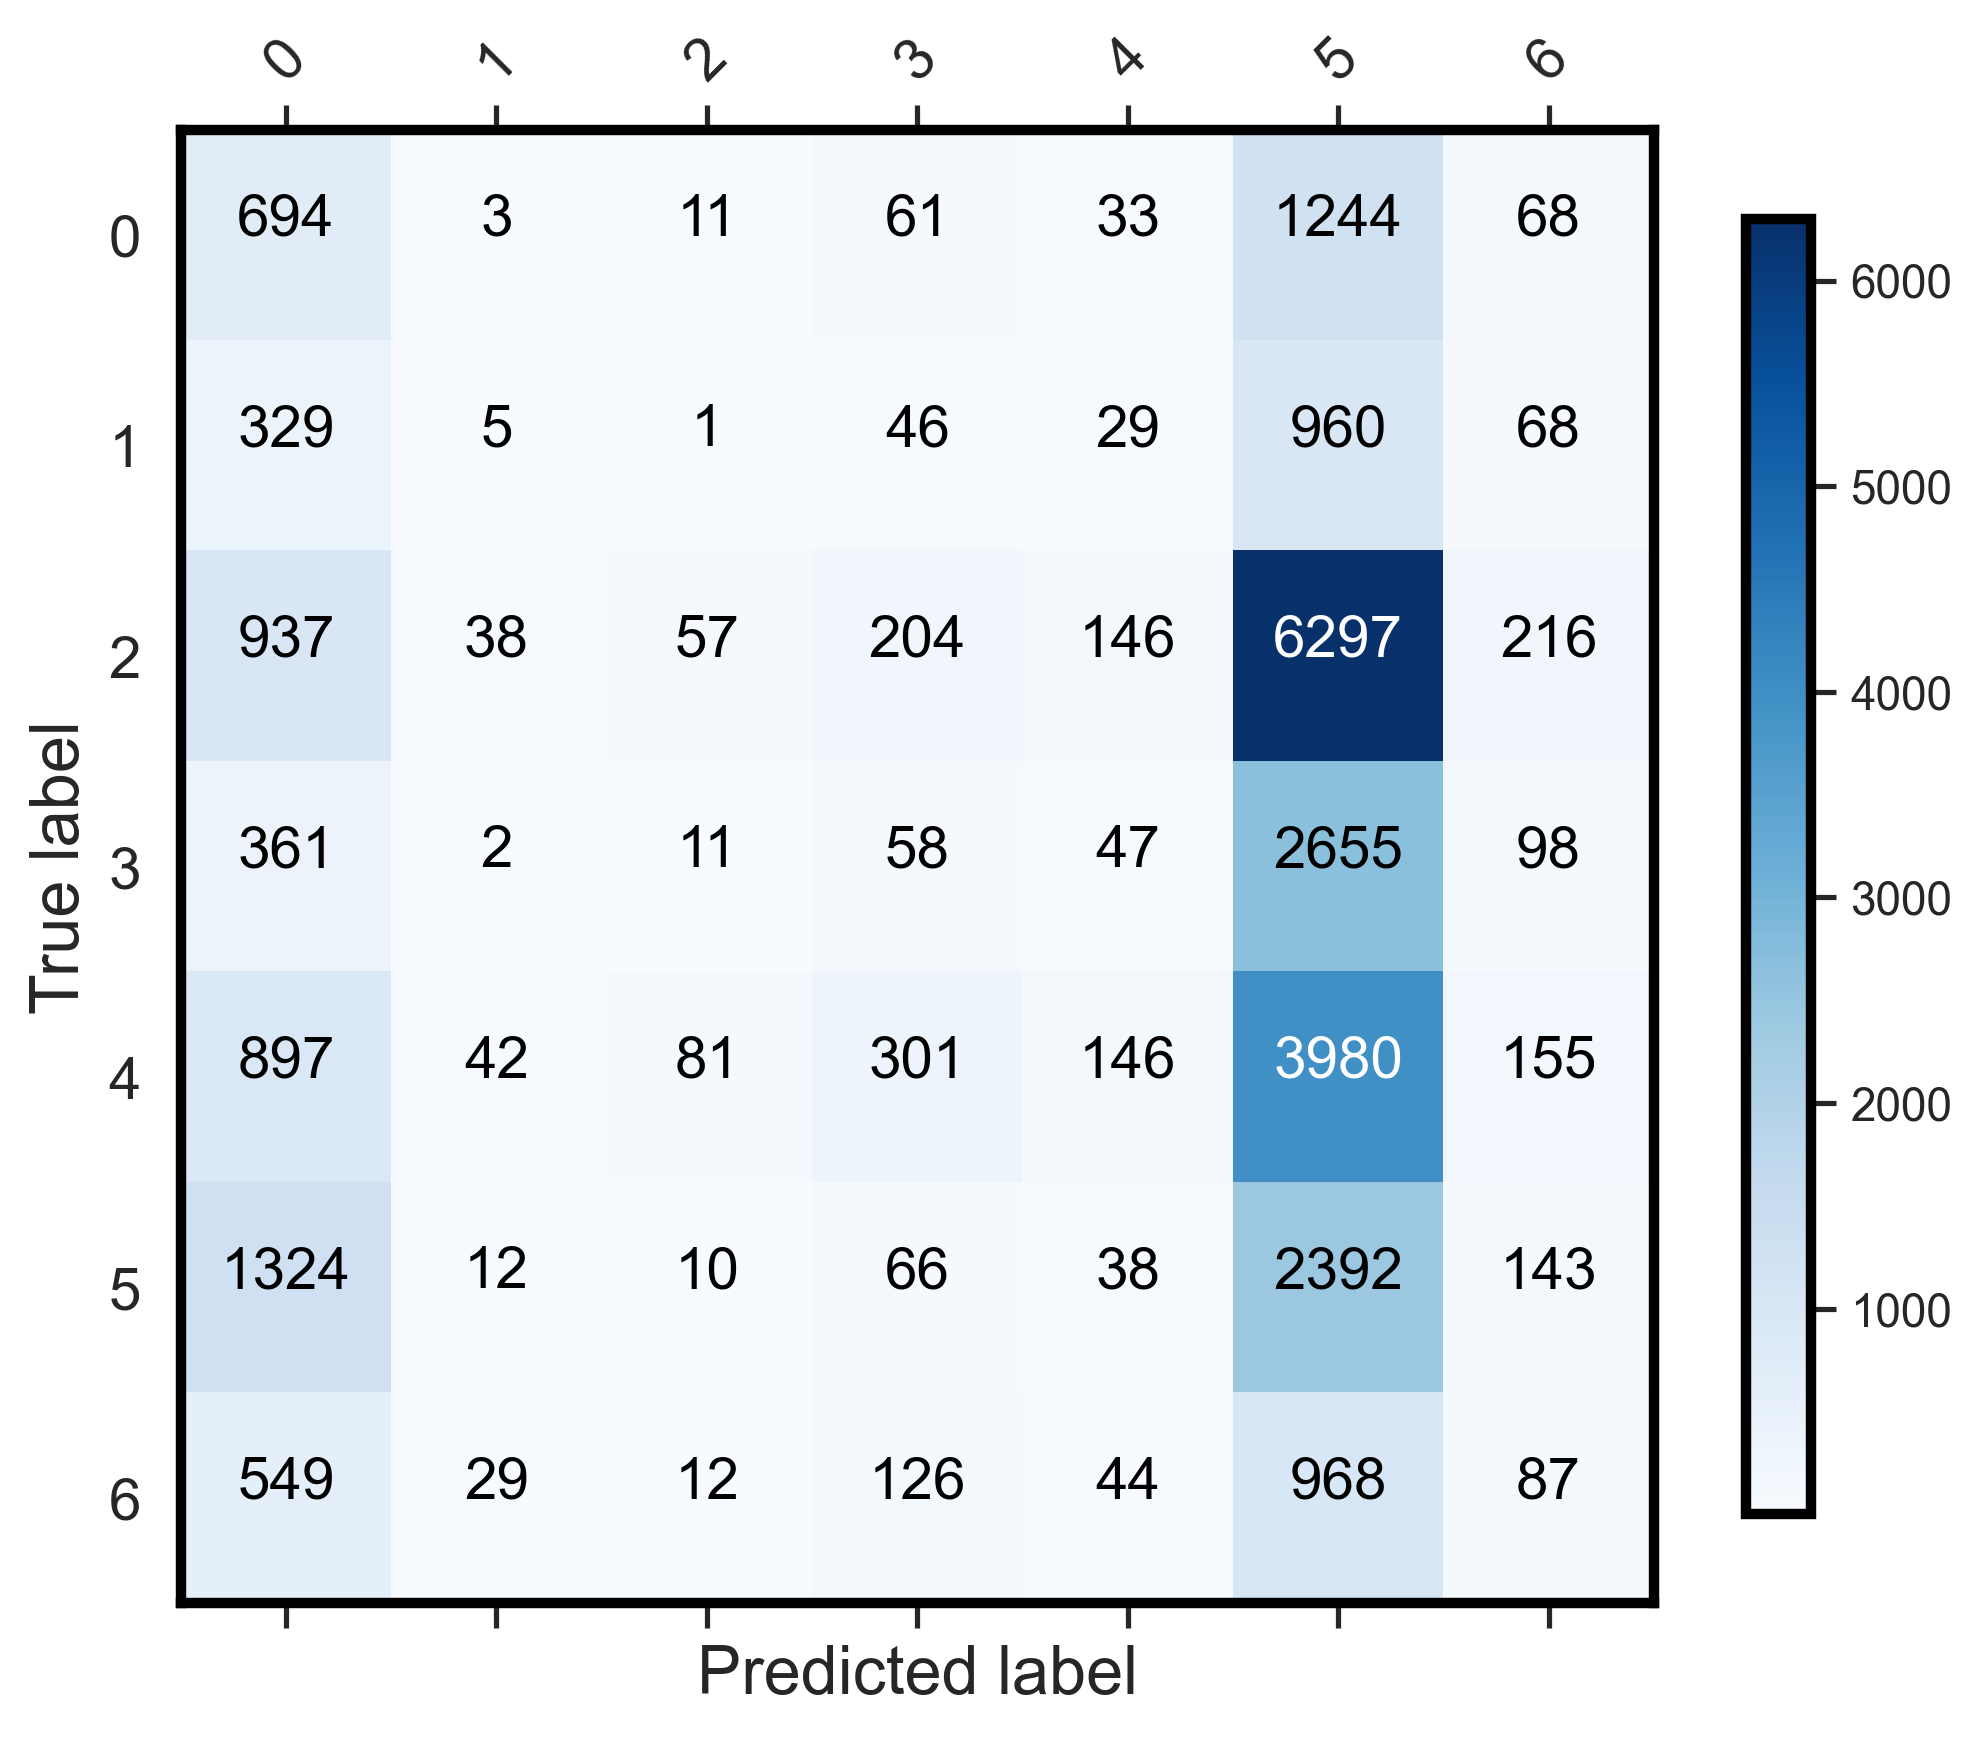

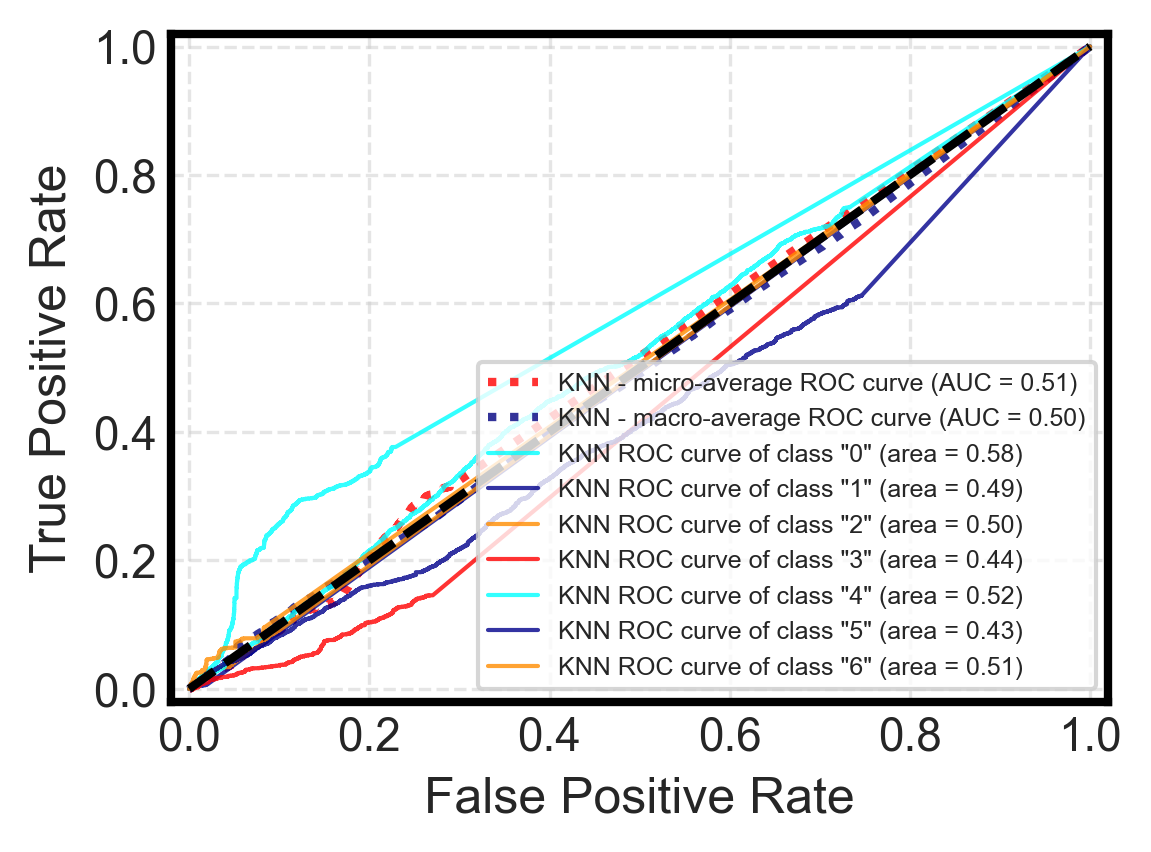

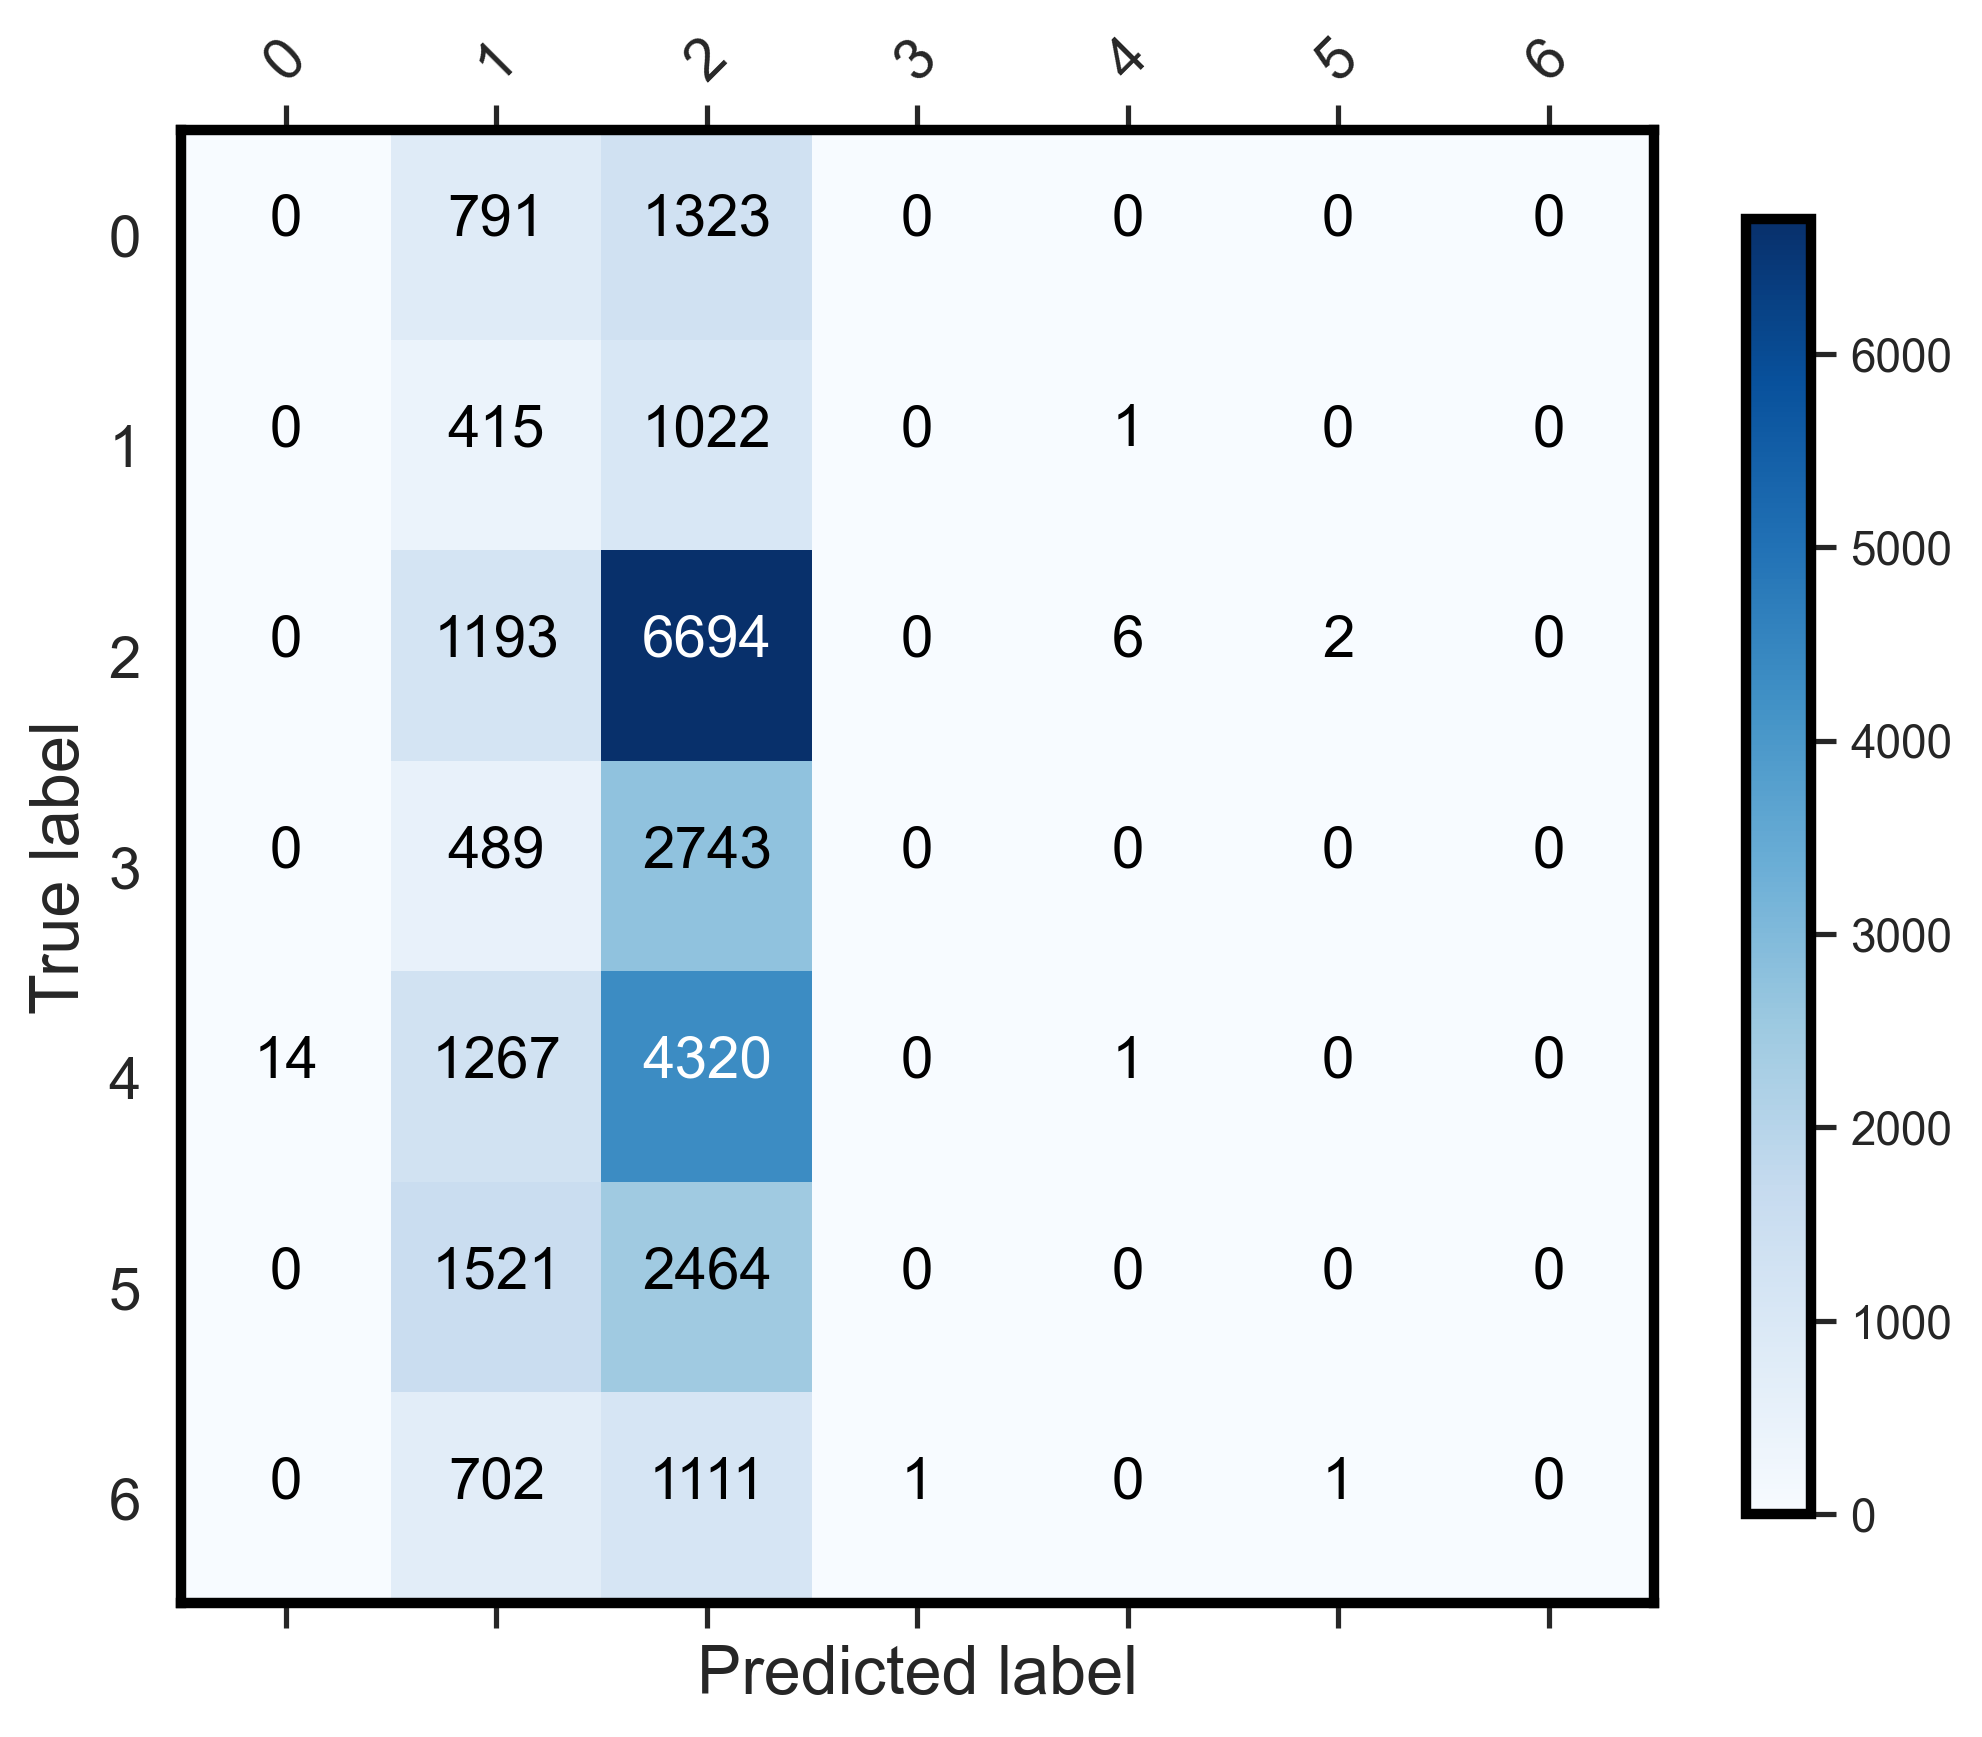

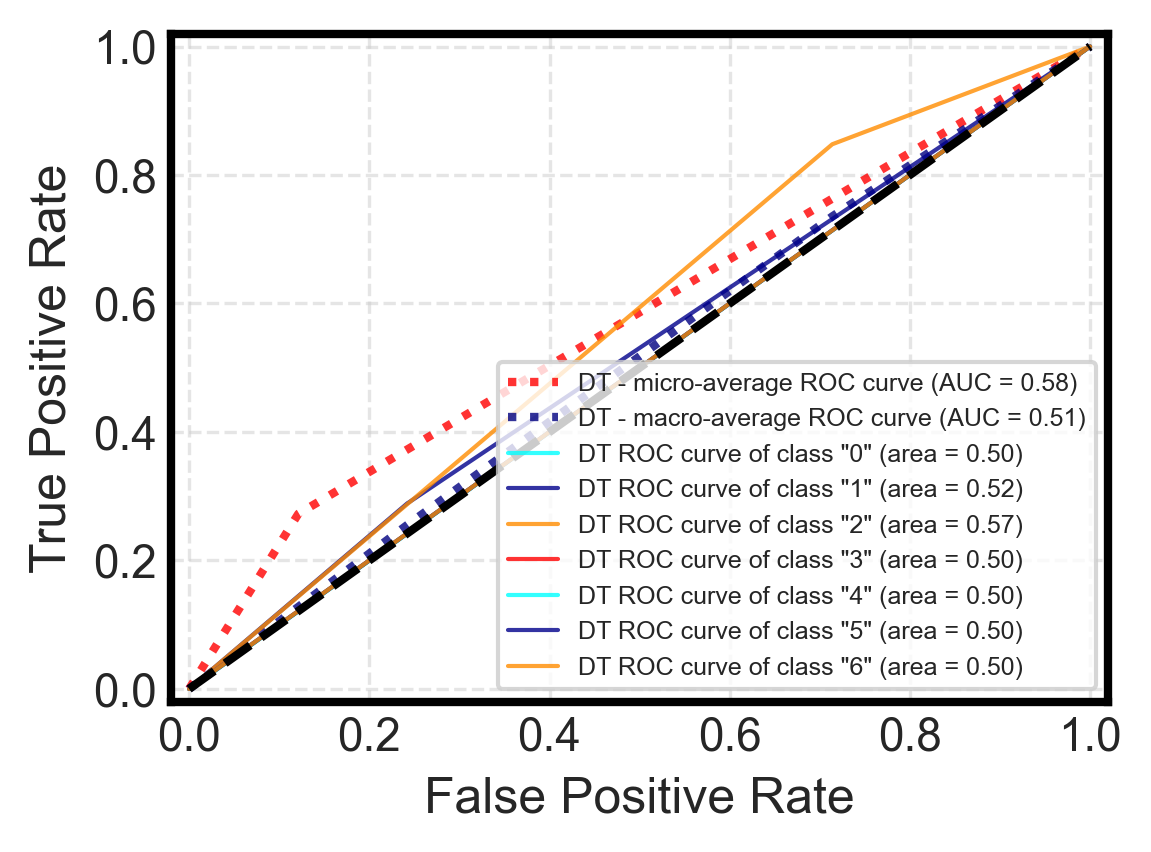

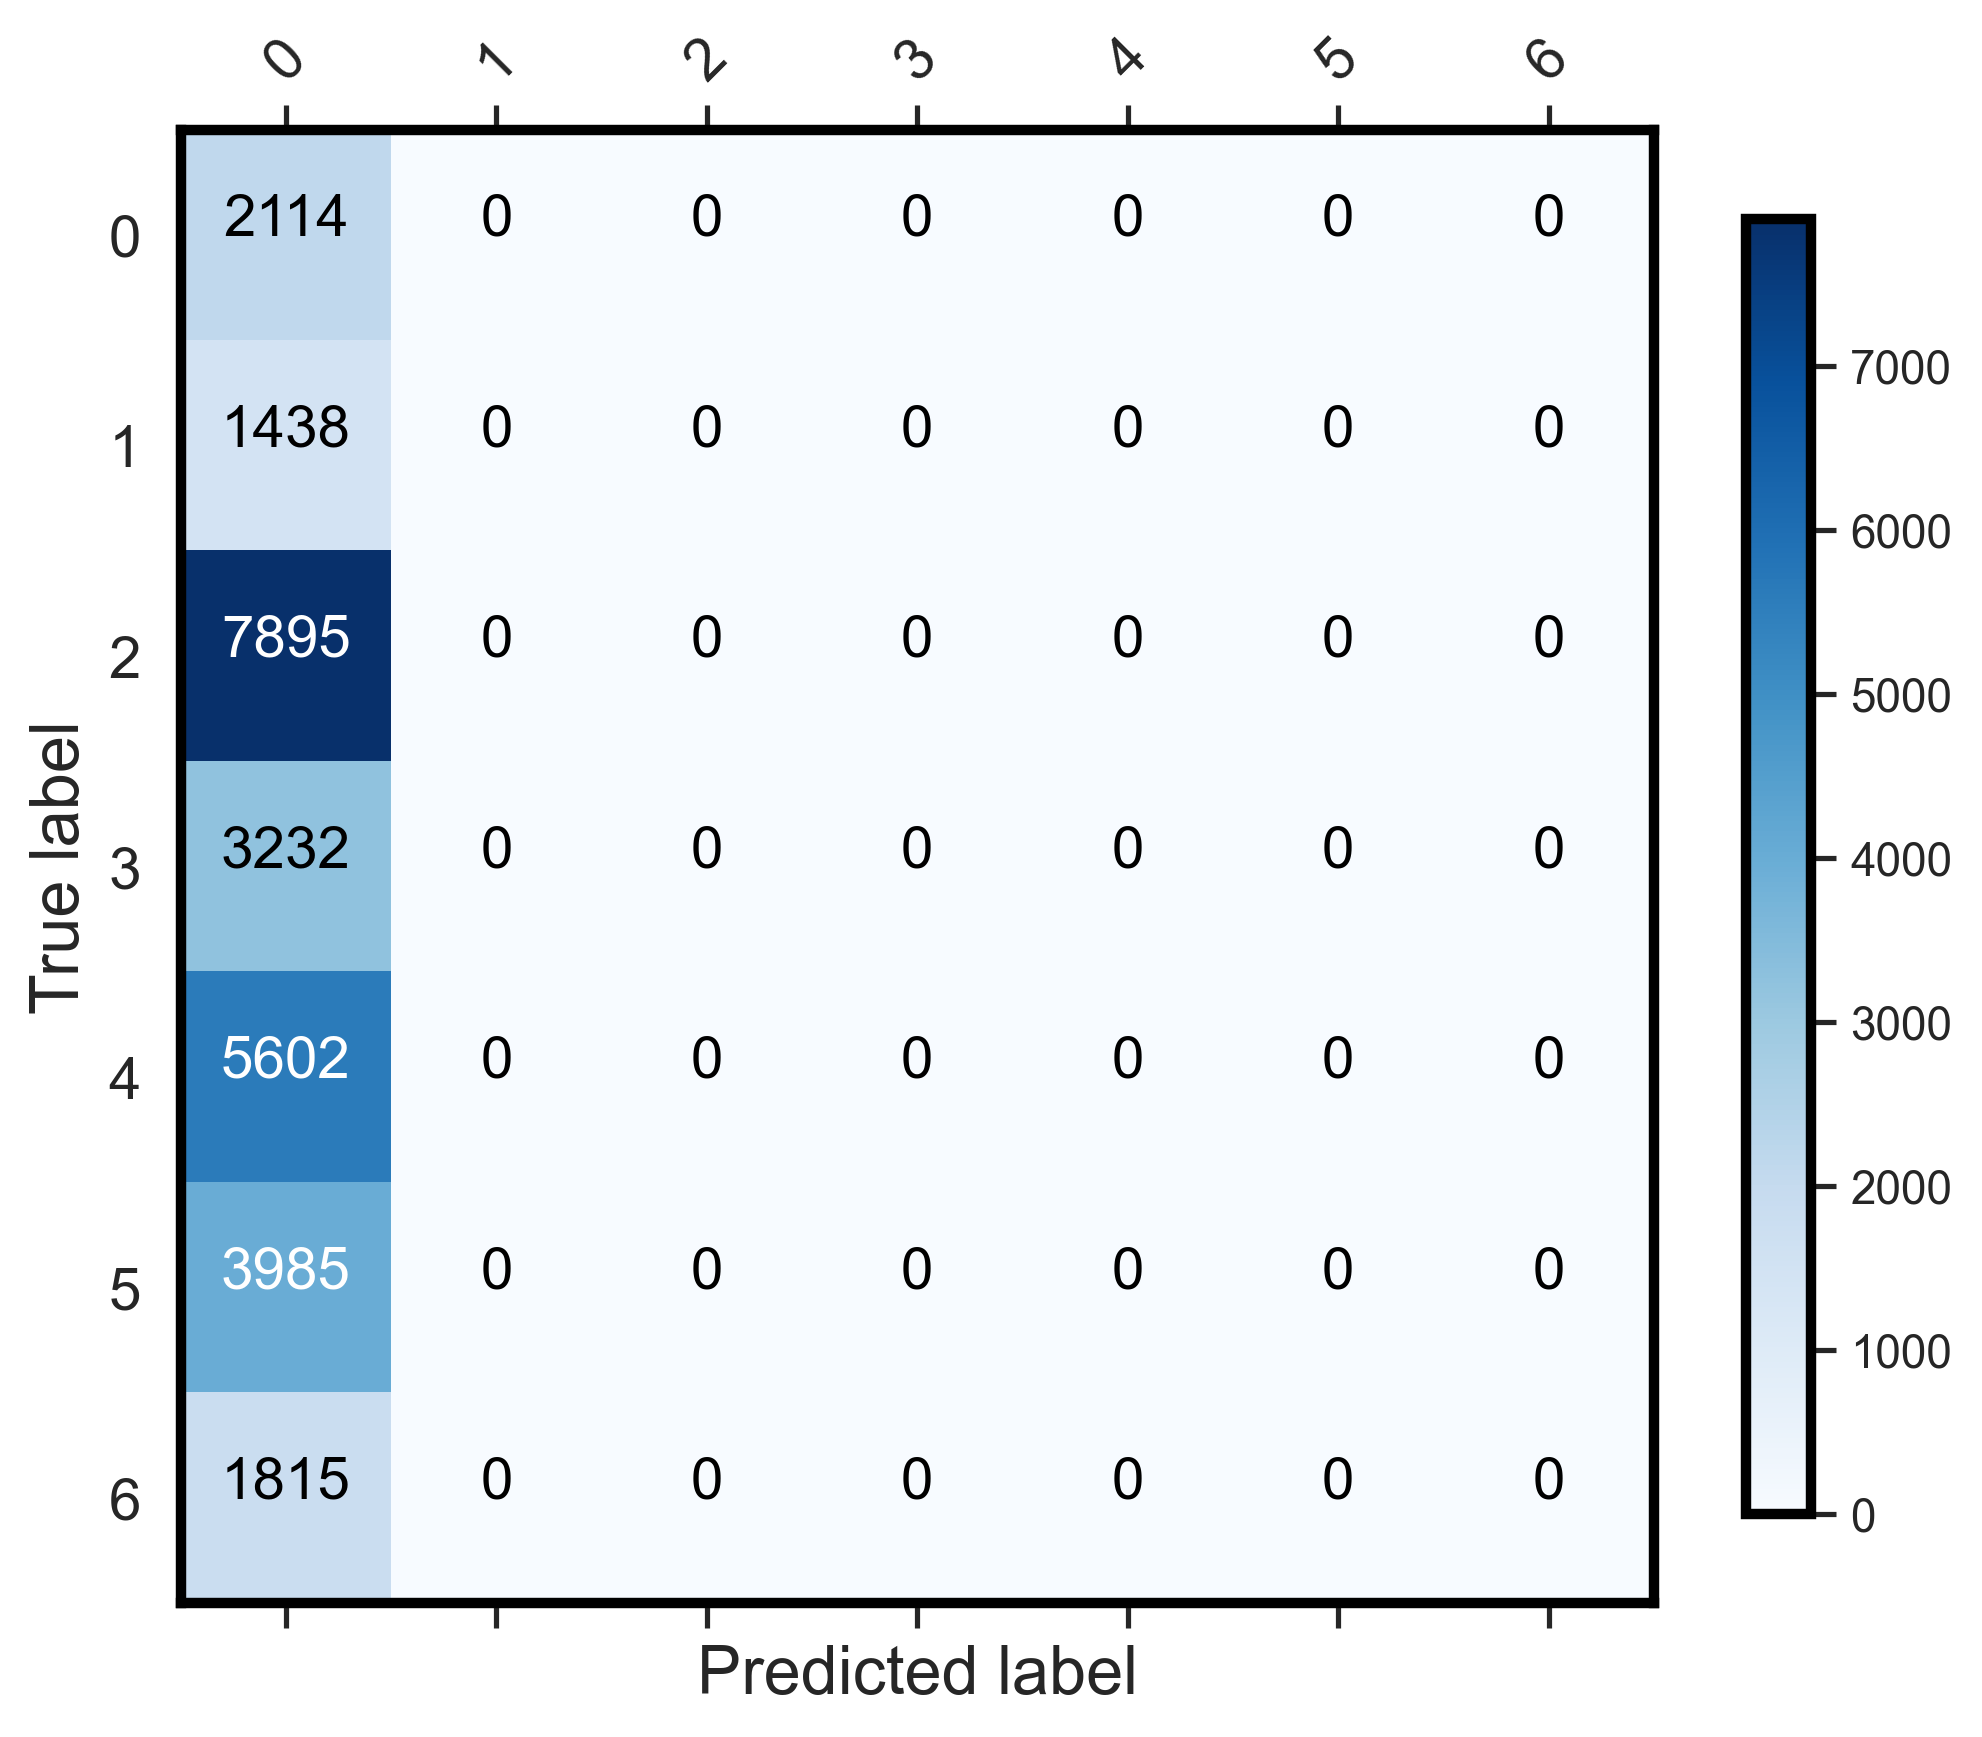

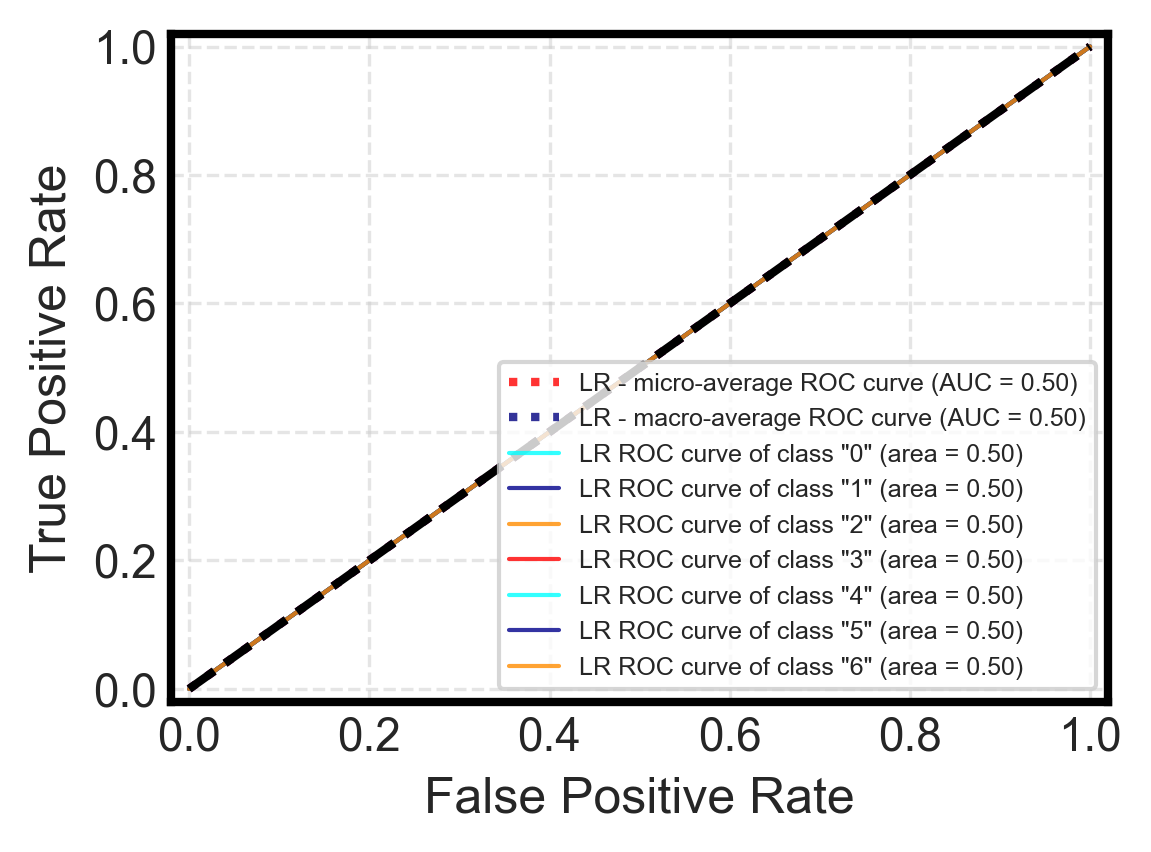

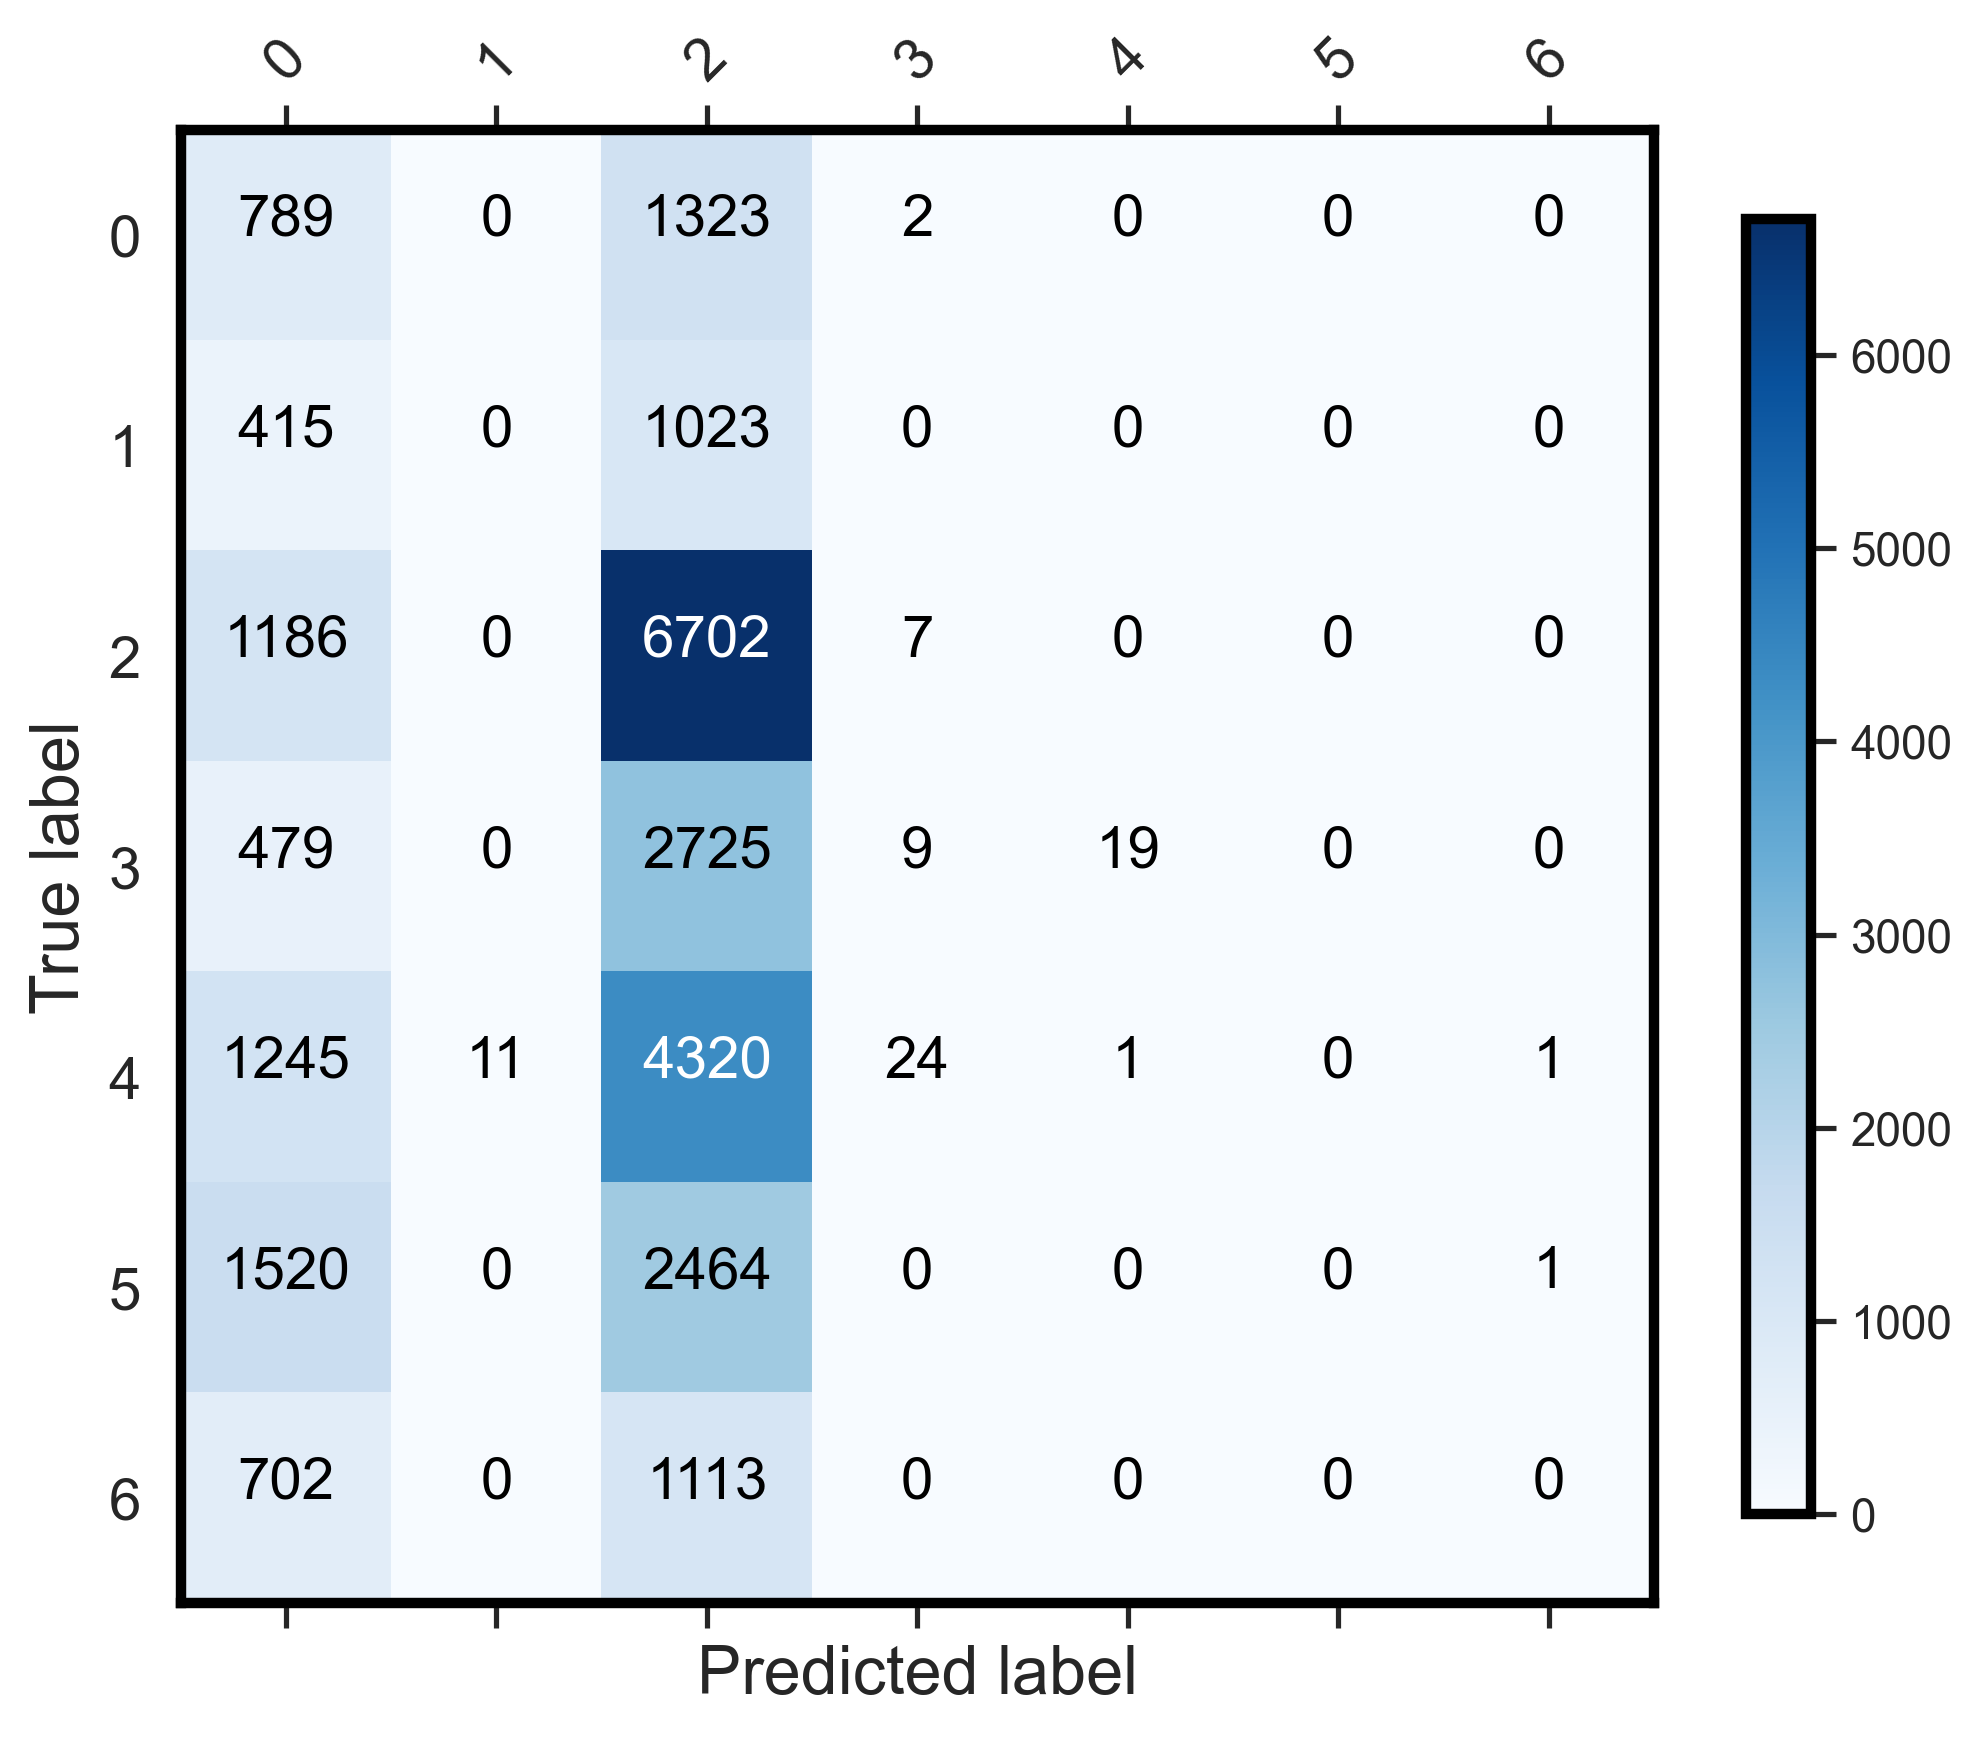

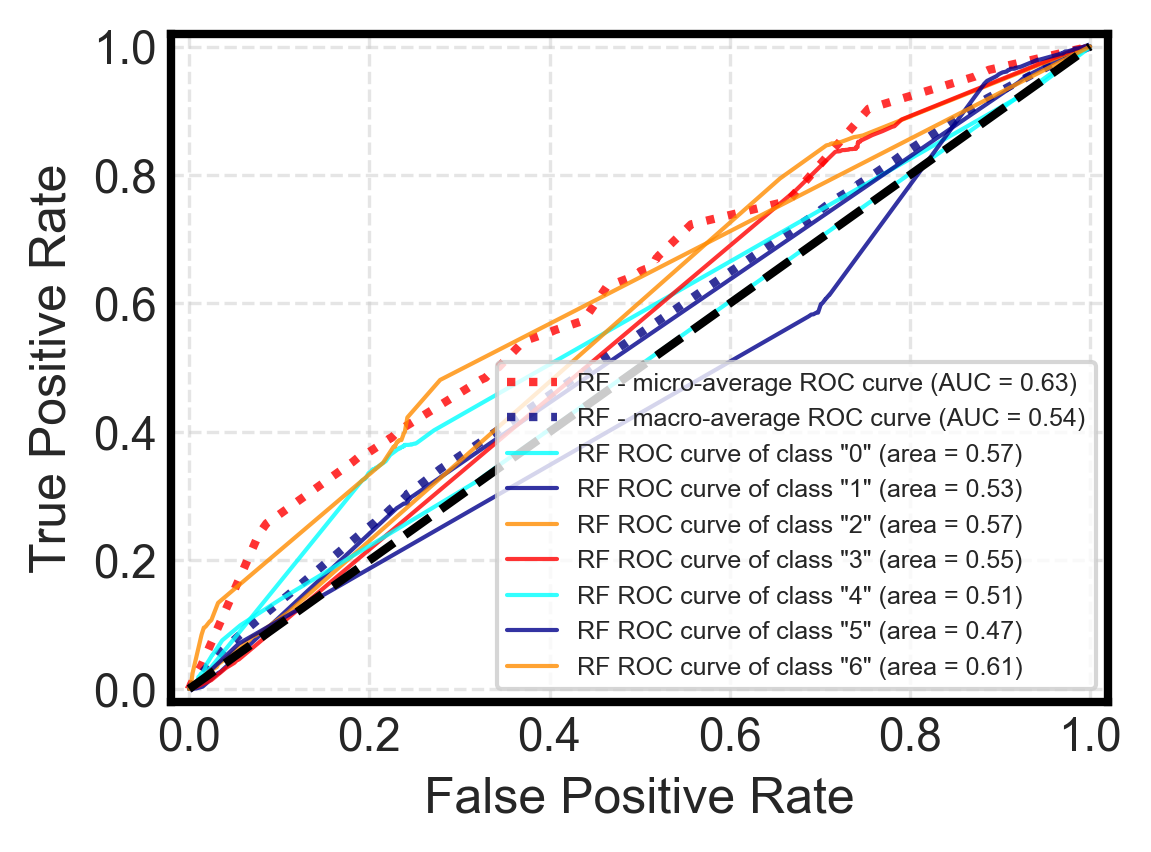

In [63]:
# Iterate over implemented models
for modeltoggle in ["KNN","DT", "LR","RF"]:  #,  "GPC", "GB", 'NN',"AdaBoost" "SVC"

    title = "Material Prediction "
    # labels_=(le_acoustic.classes_).tolist() #['Cracks', 'Defect-free', 'Keyhole pores', 'Laser-off']
    # labels_= ['aluminum', 'ferrous metal', 'non-ferrous metal', 'plastic', 'wood', 'steel', 'other']
    labels_ = [0,1,2,3,4,5,6]
    n_classes = len(labels_)
    X = X_val_transformed
    Y = Y_val
    # One-hot-encode the ouput
    Y_test_ohe = label_binarize(Y, classes=[0,1,2,3,4,5,6])
    
    
    if modeltoggle == 'RF':
        model = metamodel_RF
    elif modeltoggle == 'KNN':
        model = metamodel_KNN
    elif modeltoggle == 'AdaBoost':
        model = metamodel_AdaBoost
    elif modeltoggle == 'DT':
        model = metamodel_DT
    elif modeltoggle == 'SVC':
        model = metamodel_SVC
    elif modeltoggle == 'GB':
        model = metamodel_GB
    elif modeltoggle == 'GPC':
        model = metamodel_GP
    elif modeltoggle == 'NN':
        model = metamodel_NN
    elif modeltoggle == 'LR':
        model = metamodel_LR
    elif modeltoggle == 'NB':
        model = metamodel_NB
    
    #################--------------------------------------------------------------------#####################
    ################--------------------------------- confusion matrix ------------------#####################
    ################---------------------------------------------------------------------#####################
    # for calculating the confusion matrix
    Y_predict = model.predict(X)
    # Category/ label that was wrongly classified by the model: View the class with WRONG classificaiton 
    pred_result = list(zip(Y, Y_predict))
    result_df = pd.DataFrame(pred_result, columns = ['label', 'pred_label'])
    result_df = result_df[result_df['label'] != result_df['pred_label']]
    
    print(classification_report(Y, Y_predict))
 
    show_confusion_matrix(Y, Y_predict, classes=labels_, normalize=None, 
                     figsize=(7,7), dpi=300, fontsize=14, axis_fontsize=16, tick_size=14)

    save_fig("confusion_matrix_basic_feature" + "_" + modeltoggle  )
    
    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #################--------------------------------------------------------------------#####################
    ################------------ Testing performance on k-fold on the model -------------#####################
    ################---------------------------------------------------------------------#####################
    kf = KFold(n_splits=5)
    skf = StratifiedKFold(n_splits=5)
    trains = []
    tests = []
    
    
    # for train, test in kf.split(X):
    for train, test in skf.split(X, Y):

        X_shuffle, y_shuffle = shuffle(X, Y, random_state=0)
        y_shuffle = np.array(y_shuffle)

        # X_cv_train_before = X_shuffle[train]
        # X_cv_test_before = X_shuffle[test]
        X_train_cv = X_shuffle[train]
        X_test_cv = X_shuffle[test]
        y_train_cv = y_shuffle[train]
        y_test_cv = y_shuffle[test]
        # clf.fit(X_train_cv, y_train_cv)
        # trains.append(clf.score(X_train_cv, y_train_cv))
        tests.append(model.score(X_test_cv, y_test_cv))
    
    #################--------------------------------------------------------------------#####################
    ################--------------- AUC-ROC score measurement --------------------#####################
    ################---------------------------------------------------------------------#####################
    
    # ----------------Learn to predict each class against the other------------------------
    # classifier = OneVsRestClassifier(model)
    if modeltoggle == 'SVC':
        # y_score = classifier.fit(X_train, y_train).decision_function(X_test)
        y_score = model.decision_function(X)
    else:
        # y_score = classifier.fit(X_train, Y_train_ohe).predict_proba(X_test)
        y_score = model.predict_proba(X)
    
    # ---------------Compute ROC curve and ROC area for each class-------------------------
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test_ohe[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_ohe.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # ----------------------------------Plot all ROC curves-------------------------------
    plt.figure(figsize = (4,3), dpi = 300)
    widths = 2
    ax = gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(widths)

        tick_width = 1.5
    plt.tick_params(direction = 'in', width = tick_width)
    
         
    #---------------------------(1) micro and macro ROC curve---------------------------
    plt.plot(fpr["micro"], tpr["micro"],
             label=modeltoggle + ' - micro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='red', linestyle=':', linewidth=2, alpha = 0.8) #deeppink, midnightblue

    plt.plot(fpr["macro"], tpr["macro"],
             label=modeltoggle + ' - macro-average ROC curve (AUC = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2, alpha = 0.8) #navy, gold
    
    #---------------------------(2) ROC curve for each class---------------------------
    colors = cycle(["aqua", "darkblue", "darkorange", "red"])
    # colors = cycle(['0.45', 'steelblue',  'olive', 'silver'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i],tpr[i],color=color,
                 lw=1, alpha = 0.8,
                 label=modeltoggle + " ROC curve of class \"{0}\" (area = {1:0.2f})".format(labels_[i], roc_auc[i])) 
        
        

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plt.title("ROC curve")
    plt.legend(loc="lower right",  fontsize = '6', frameon = True, framealpha=0.8)
    # plt.show()
    plt.grid(linestyle='--', alpha=0.5, linewidth=0.8)
    
    #---------------------------------Aggregate information----------------------------------
 
    # trains = np.array(trains)
    tests = np.array(tests)

    test_accuracy_mean = tests.mean()
    test_accuracy_std = tests.std()
    # train_accuracy_mean = trains.mean()
    # train_accuracy_std =  trains.std()
    
    
    auc_score_list = []
    auc_score_list.append(auc(fpr["micro"], tpr["micro"]))
    
    auc_score_array = np.array(auc_score_list)
    auc_mean = auc_score_array.mean()
    auc_std = auc_score_array.std()
    
    
    # store into list
    auc_mean_list.append(auc_mean)
    auc_std_list.append(auc_std)
    accuracy_mean_list.append(test_accuracy_mean)
    accuracy_std_list.append(test_accuracy_std)
    
    print('Test Accuracy (cross-validation) for' , modeltoggle, '= {:.5f} ± {:.5f}'.format(test_accuracy_mean, test_accuracy_std))
    print('micro-averaging AUC for' , modeltoggle, '= {:.5f} ± {:.5f}'.format(auc_mean, auc_std))
    save_fig("ROC_" + modeltoggle + "_" + "basic_feature")

### Save trained model into folder

In [66]:
# Save Model Using Pickle
# ["KNN","DT", "LR", "SVC","GB", "RF" ]
# save the model to disk
metamodel_KNN_file = os.path.join(ML_model_PATH, 'metamodel_KNN.sav')
metamodel_DT_file = os.path.join(ML_model_PATH, 'metamodel_DT.sav')
metamodel_LR_file = os.path.join(ML_model_PATH, 'metamodel_LR.sav')
# metamodel_SVC_file = os.path.join(ML_model_PATH, 'metamodel_SVC.sav')
# metamodel_GB_file = os.path.join(ML_model_PATH, 'metamodel_GB.sav')
metamodel_RF_file = os.path.join(ML_model_PATH, 'metamodel_RF.sav')
# metamodel_GP_file = os.path.join(ML_model_PATH, 'metamodel_GP.sav')
# metamodel_NN_file = os.path.join(ML_model_PATH, 'metamodel_NN.sav')

pickle.dump(metamodel_KNN, open(metamodel_KNN_file, 'wb'))
pickle.dump(metamodel_DT, open(metamodel_DT_file, 'wb'))
pickle.dump(metamodel_LR, open(metamodel_LR_file, 'wb'))
# pickle.dump(metamodel_SVC, open(metamodel_SVC_file, 'wb'))
# pickle.dump(metamodel_GB, open(metamodel_GB_file, 'wb'))
pickle.dump(metamodel_RF, open(metamodel_RF_file, 'wb'))
# pickle.dump(metamodel_GP, open(metamodel_GP_file, 'wb'))
# pickle.dump(metamodel_NN, open(metamodel_NN_file, 'wb'))

In [67]:
# load the model from disk
loaded_RF = pickle.load(open(metamodel_RF_file, 'rb'))
result = loaded_RF.score(X_val_transformed, Y_val)
print(result)

-1.2601297563406568


## Model performance statistics

In [72]:
# Sample data
models = ["KNN", "DT", "LR", "RF"]

## dummy - tentative
accuracy_std_list = [0.02, 0.03, 0.015, 0.01]
accuracy_mean_list = [0.78, 0.75, 0.82, 0.85]
auc_mean_list = [0.8, 0.78, 0.85, 0.88]
auc_std_list = [0.03, 0.025, 0.02, 0.015]


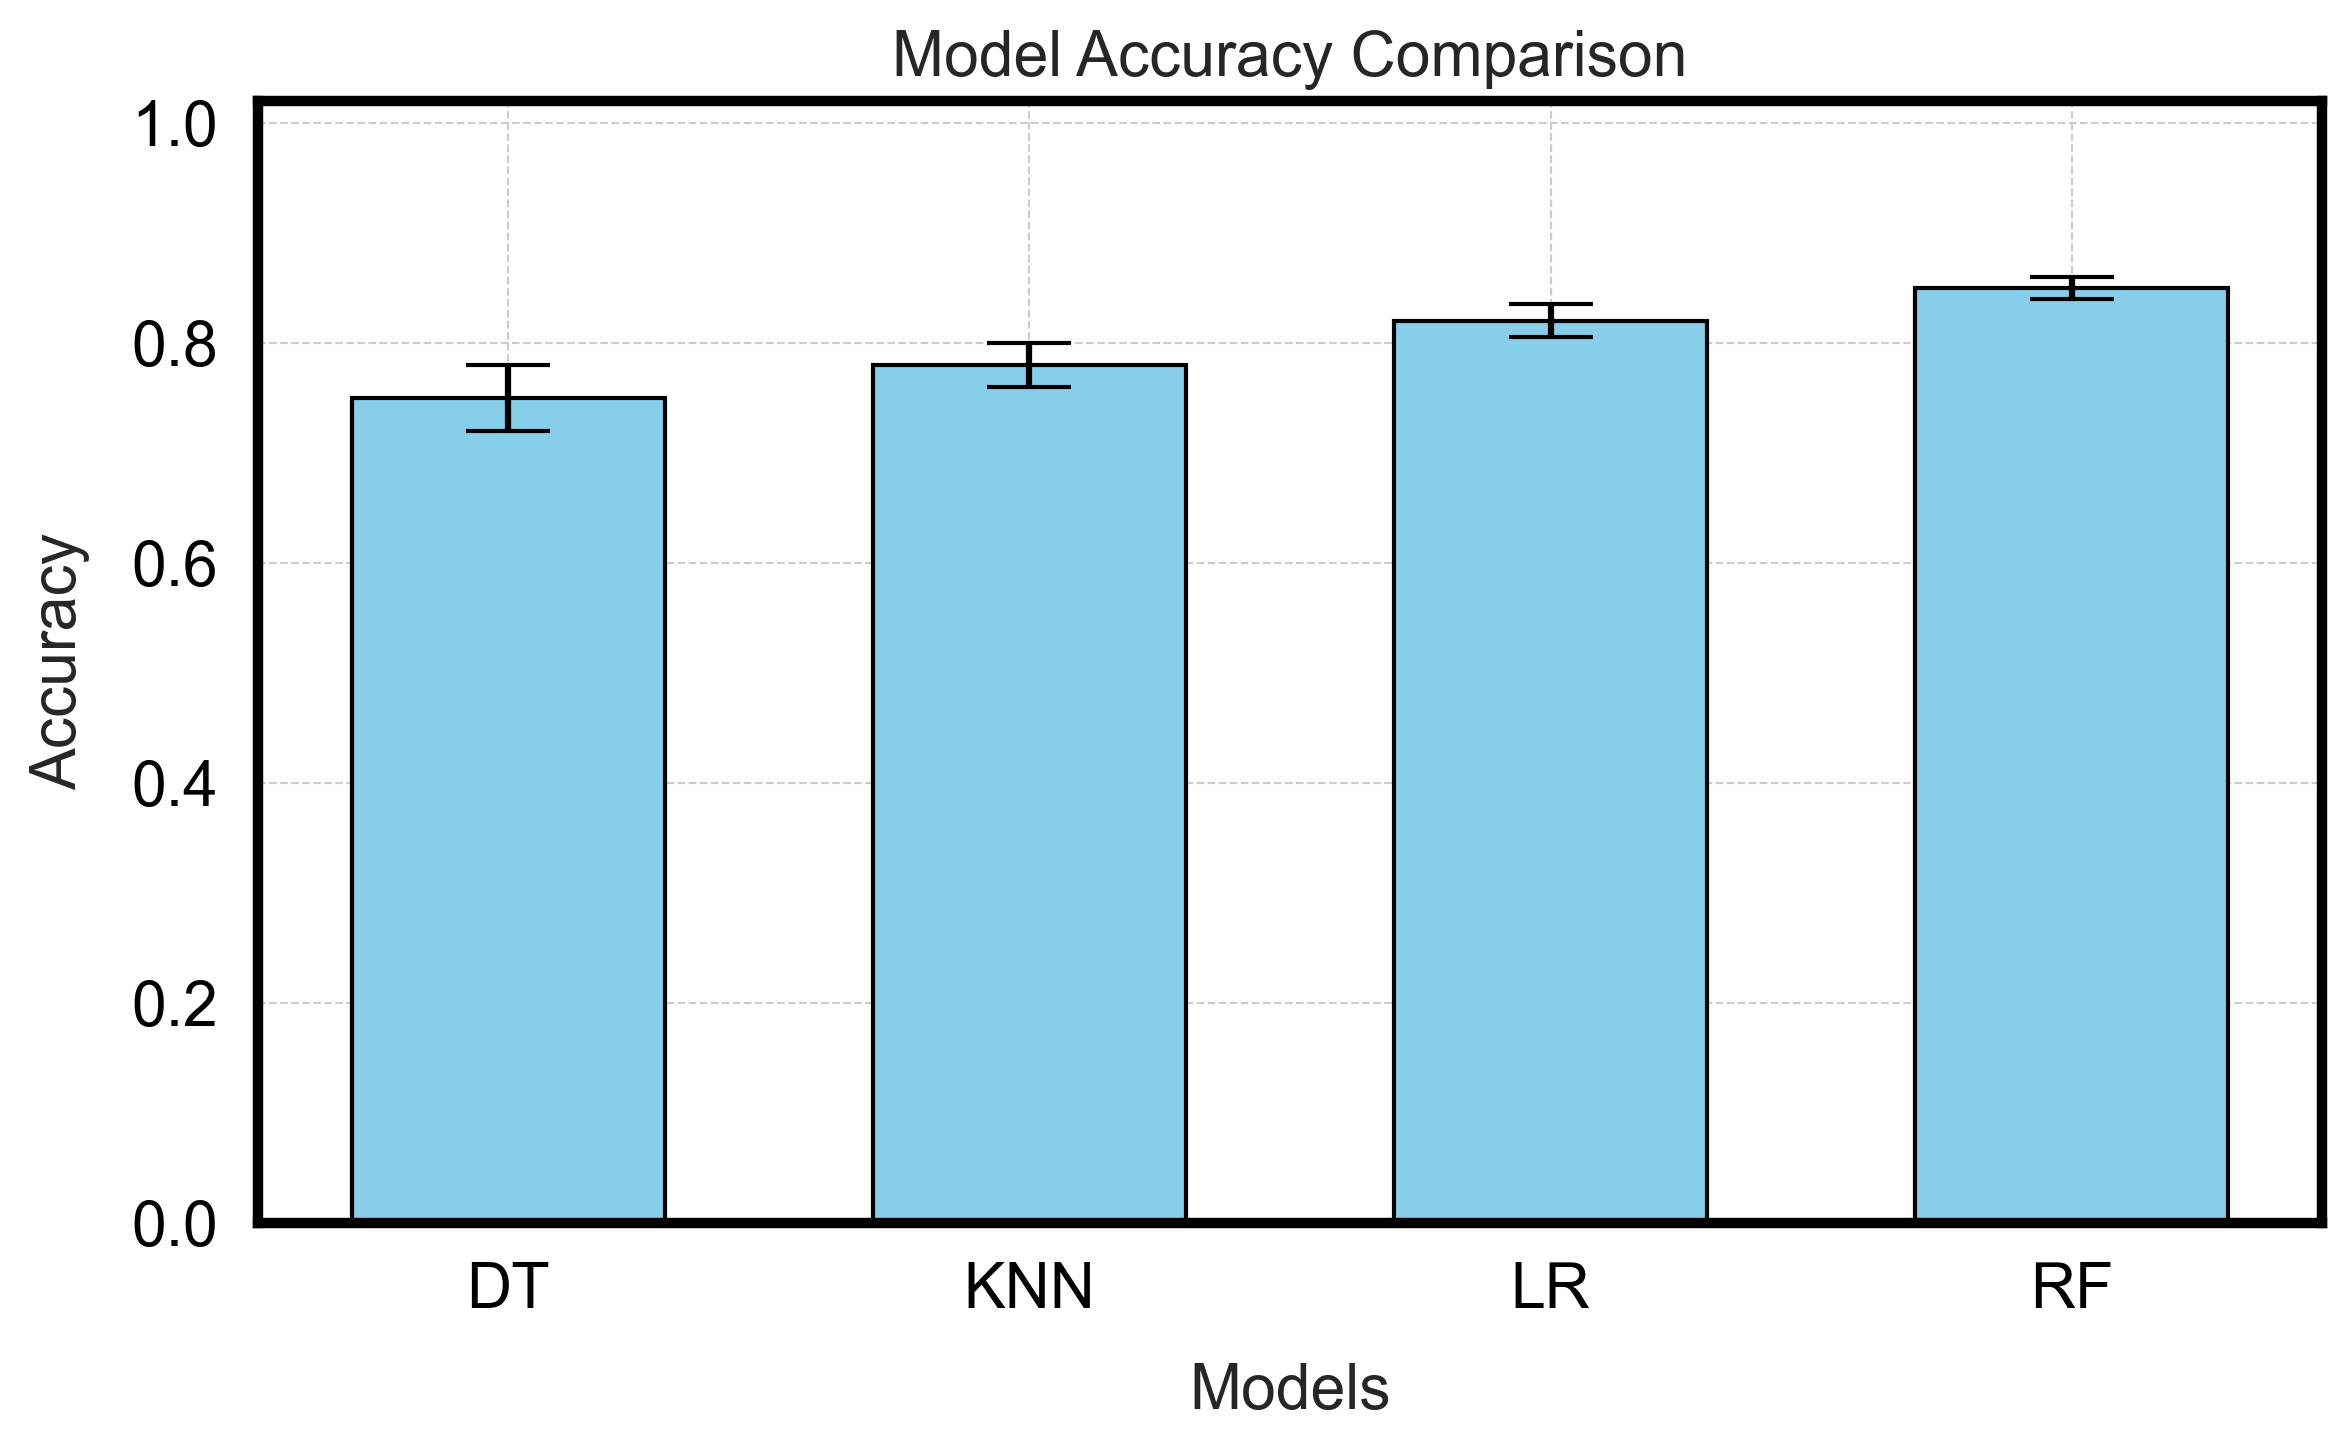

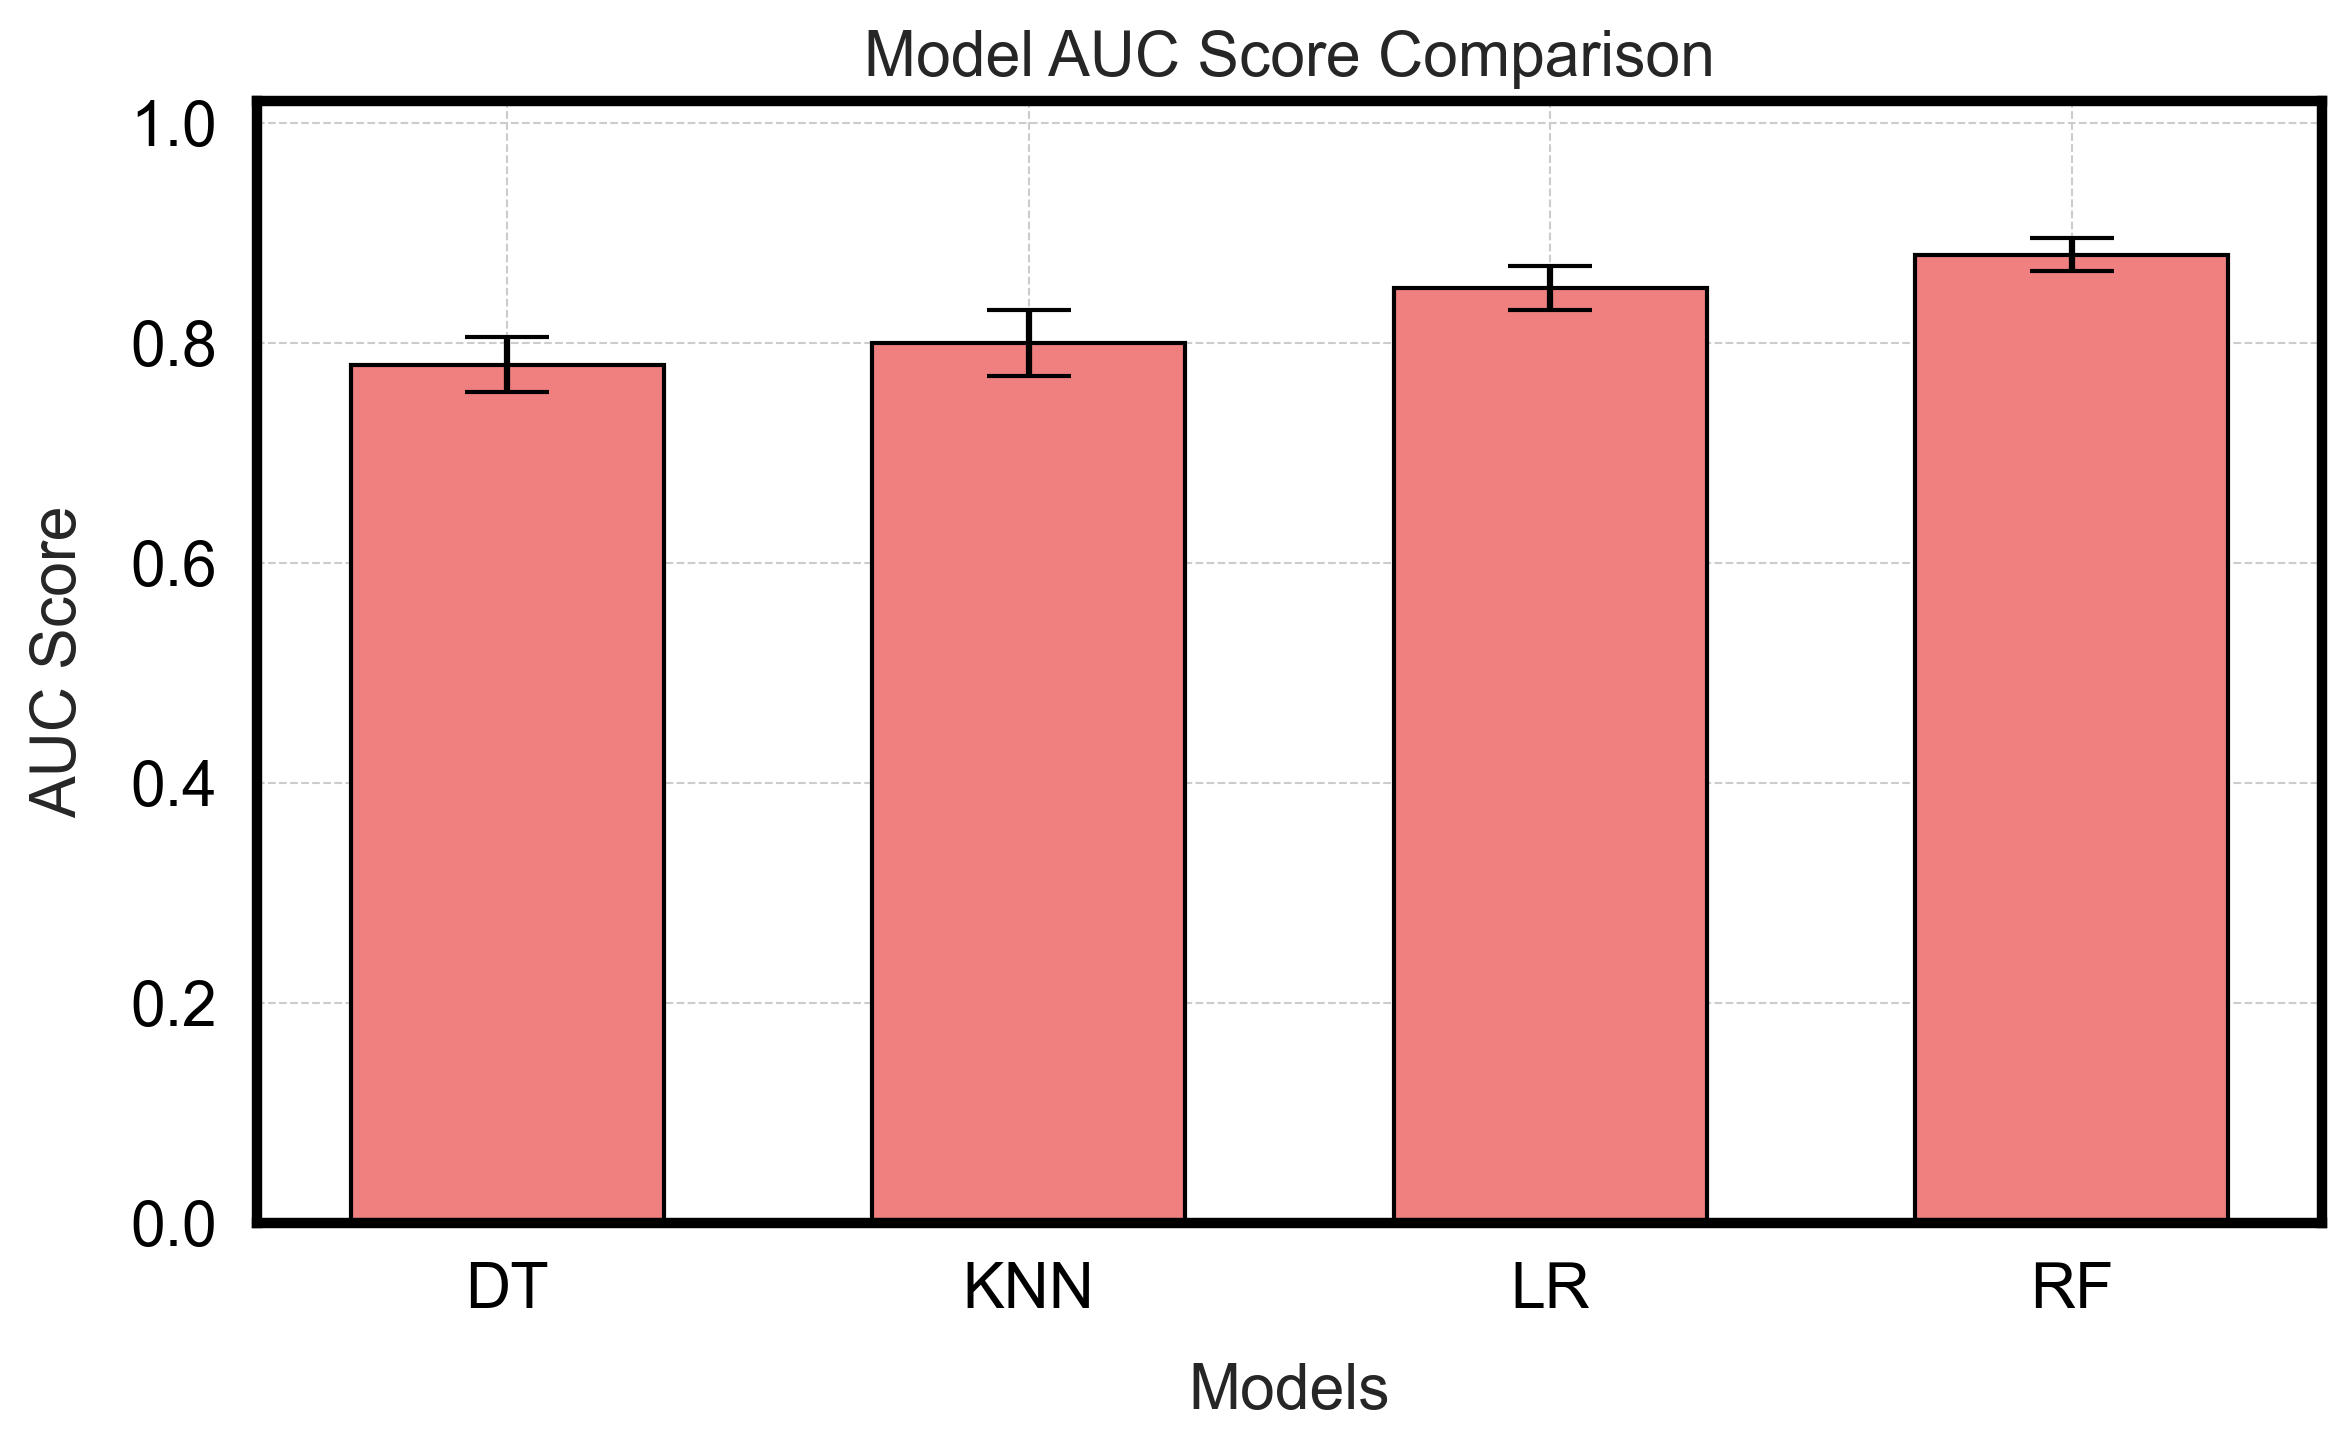

In [88]:
def plot_model_metrics_with_improvements(models, mean_list, std_list, metric_name, color, bar_width=0.6, edge_width=1, 
                                         fontsize=15, labelpad=10, figsize=(8, 5), dpi=300):
    
    # Sorting by mean values
    sorted_indices = np.argsort(mean_list)
    sorted_models = np.array(models)[sorted_indices]
    
    # Plotting
    plt.figure(figsize=figsize, dpi=dpi)
    plt.bar(sorted_models, np.array(mean_list)[sorted_indices], 
            yerr=np.array(std_list)[sorted_indices], 
            capsize=10, 
            color=color, 
            width=bar_width, 
            edgecolor='black', 
            linewidth=edge_width)
    
    plt.ylabel(metric_name, fontsize=fontsize, labelpad=labelpad)
    plt.title(f'Model {metric_name} Comparison', fontsize=fontsize)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel("Models", fontsize=fontsize, labelpad=labelpad)
    
    # Add dotted grid
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    
    # Show ticks outwards
    plt.tick_params(direction='out', length=6, width=2, colors='black')
    
    plt.tight_layout()
    plt.ylim([0, 1.02])
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8 , 1.0])
    # plt.show()

# Plotting Accuracy with improvements
plot_model_metrics_with_improvements(models, accuracy_mean_list, accuracy_std_list, "Accuracy", 'skyblue')

# Plotting AUC with improvements
plot_model_metrics_with_improvements(models, auc_mean_list, auc_std_list, "AUC Score", 'lightcoral')


# Make predictions on the test set, and save the results.

## Conclusion
From the results we can see that the model is not doing very well.
It achieves an accuracy of 0.26.
From the confusion matrix we can see that most of the bodies are classified as `other`.

This approach could be further improved by changing the prompt, providing more contextual information to the LLM, and many more ways.
We look forward to seeing your solutions!